# **Traffic prediction on luxembourg highway with LSTM and VAR**

## - **Objectif of the study**

With the rapid development of science and technology, more and more smart sensors are deployed in cities today. Through the data obtained by these sensors, we can analyze and process to draw conclusions. Make our city more convenient and efficient, and use data analysis to better serve the citizens.


## - **Introduction of the data**
This time we have traffic data from the Luxembourg highway. We can use some machine learning or deep learning methods to predict the data. It can provide drivers with traffic conditions for going out.

We select the data of sensors on the Luxembourg highways to analyze the conditions of the Luxembourg highways.

The data analyzed was captured by the 186 cameras of cita.lu between 19/11/2019 and 26/12/2019 on the seven Luxembourg highways. Data for each camera is updated every 5 minutes. For this period, this represents a data set of 1,887,379 records. If we extrapolate to 1 year, this represents approximately 18,130,000 records. The 3 main measurements available for each camera every 5 minutes are:

- Average speed in km/h 

- Traffic concentration in percentage 

- Traffic flow in number of cars per hour 

Data details Motorway traffic in Luxembourg times series contains 10 types of data:

- Camera ID

- Measurement timestamp

- Direction ( from town, to town)

- Latitude and longitude of the camera

- Distance from the camera to the start of the motorway (camera at km x)

- Average speed in km/h

- Traffic concentration in percentage

- Traffic flow in number of cars per hour

The Columns of our dataframe are ```['id','time','latitude','longitude','direction','road','trafficStatus','avgVehicleSpeed','vehicleFlowRate','trafficConcentration']```

But in the following predictions, we only focus on the three variables ```['avgVehicleSpeed','vehicleFlowRate','trafficConcentration'].```

We can get the data from the data source link: https://data.public.lu/en/datasetscita-donnees-trafic-en-datex-ii/

The real time traffic status can be viewed on the site: https://cita.lu/en


![picture](https://drive.google.com/uc?export=view&id=1AKcpy4BpX4uSdUgdboHbja-WJl7Nfnem)

## - **Goals and plan**
Because the amount of data is too large, we will select the road numbered A3 for analysis and prediction of time series.

The sensor can detect the speed of the car on the road, the traffic flow in number of cars per hour and the degree of traffic congestion. Then we can make good use of these data for analysis and processing, use past data to predict future traffic conditions, feed the predicted results back to local drivers, suggest the time of going out, and so on. For example, we can use the road conditions in the past few hours to predict the road conditions in the next 1-2h to update in real time, so that the driver can always know the situation on a certain highway.

So our project is structured as follows:

- Load the data from the csv file
- Visualize the data
- Process the data
- Choose the model for time series
- Train and test model and evaluate

- Compare the results for the two models LSTM and VAR

##- **The models for the time series**

There are some specific models in machine learning that can predict the future from the past. Of course, there are also many models in deep learning (using neural network).

Depending on whether it is univariate time serie analysis or multivariate time serie, different types of models can be used. For univariate time serie analysis, the more classic models are the ARIMA model, and for the multivariate time series, the available models are LSTM, VAR, prophet, etc.

From a theoretical perspective, VAR does not include moving-average (MA) terms and approximates any existing MA patterns by extra autoregressives lags, which is a less parsimonious solution than directly including MA terms as in an ARIMAX model. On the other hand, VAR can be estimated using OLS(Ordinary Least Square) or GLS(General Least Square) which are generally fast, while ARIMAX requires maximum likelihood estimation which is generally slow.

Traditional linear models are difficult to solve multi-variable or multi-input problems, while neural networks such as LSTM are good at dealing with multi-variable problems. This feature makes it helpful to solve time series forecasting problems.

## **- The models to be used in this project**

In this project, we'll use the model LSTM and VAR to predict the traffic condition on the highway A3 and compare the two different models to see the effect.

So here I will introduce these two models briefly:

- **LSTM**

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. We will use it to predict multivariate time series with our traffic data. In details, we will use the sequence to sequence learning for time series forecasting. For example, we use the traffic volume and speed of current and last cameras in the first 50 minutes as input, and predict the speed and traffic volume in the next 15 minutes as output.

- **VAR**

Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other. So it is very suitable for us to predict the multi-variable time series of vehicle speed, vehicle flow and traffic concentration under this data set. We will see the concepts, intuition behind VAR models and see a comprehensive and correct method to train and forecast VAR models in python using statsmodels

## **File loading and importing python script and modules**




In [49]:
# Mounting drive
'''Mount google drive on google Colab in order to import files from google drive'''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change the working directory into the path where you place all the data files(.csv)
import os
path = '/content/drive/MyDrive/TX_Machine Learning'
os.chdir(path)
print(os.getcwd())

# Upload custom function python file(.py) from your local computer
from google.colab import files
if os.path.exists(path + '/util.py'): # File already existe
  from util import *
else:
  print("Please upload your function file from your computer:")
  files.upload()
  from util import *

### Package for processing data and data visualization
import pandas as pd 
import numpy as np
import missingno as msno
import math

### Python's standard library for processing dates and times
from datetime import datetime

### Package for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

### Package for print the map
import networkx as nx

### packages for LSTM and Scikit-learn module package
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score,SCORERS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn')


Mounted at /content/drive
/content/drive/MyDrive/TX_Machine Learning


### **Preparing the raw data and having a look at the relative position of each camera**



- We could only import datexDataA3.txt, because we only focus on A3 highways. But in order to show the geographic location of each camera, here we import all the data.

In [50]:
### get the path of every file for showing the following map
directory = "./data/"
files = ['datexDataA1.csv', 'datexDataA3.csv', 'datexDataA4.csv', 'datexDataA6.csv', 'datexDataA7.csv', 'datexDataA13.csv', 'datexDataB40.csv']

### get the raw dataframe
raw_data = load_raw_data(directory, files)

datexDataA1.csv is finished with 631072
datexDataA3.csv is finished with 408457
datexDataA4.csv is finished with 408871
datexDataA6.csv is finished with 766054
datexDataA7.csv is finished with 426624
datexDataA13.csv is finished with 816868
datexDataB40.csv is finished with 177540


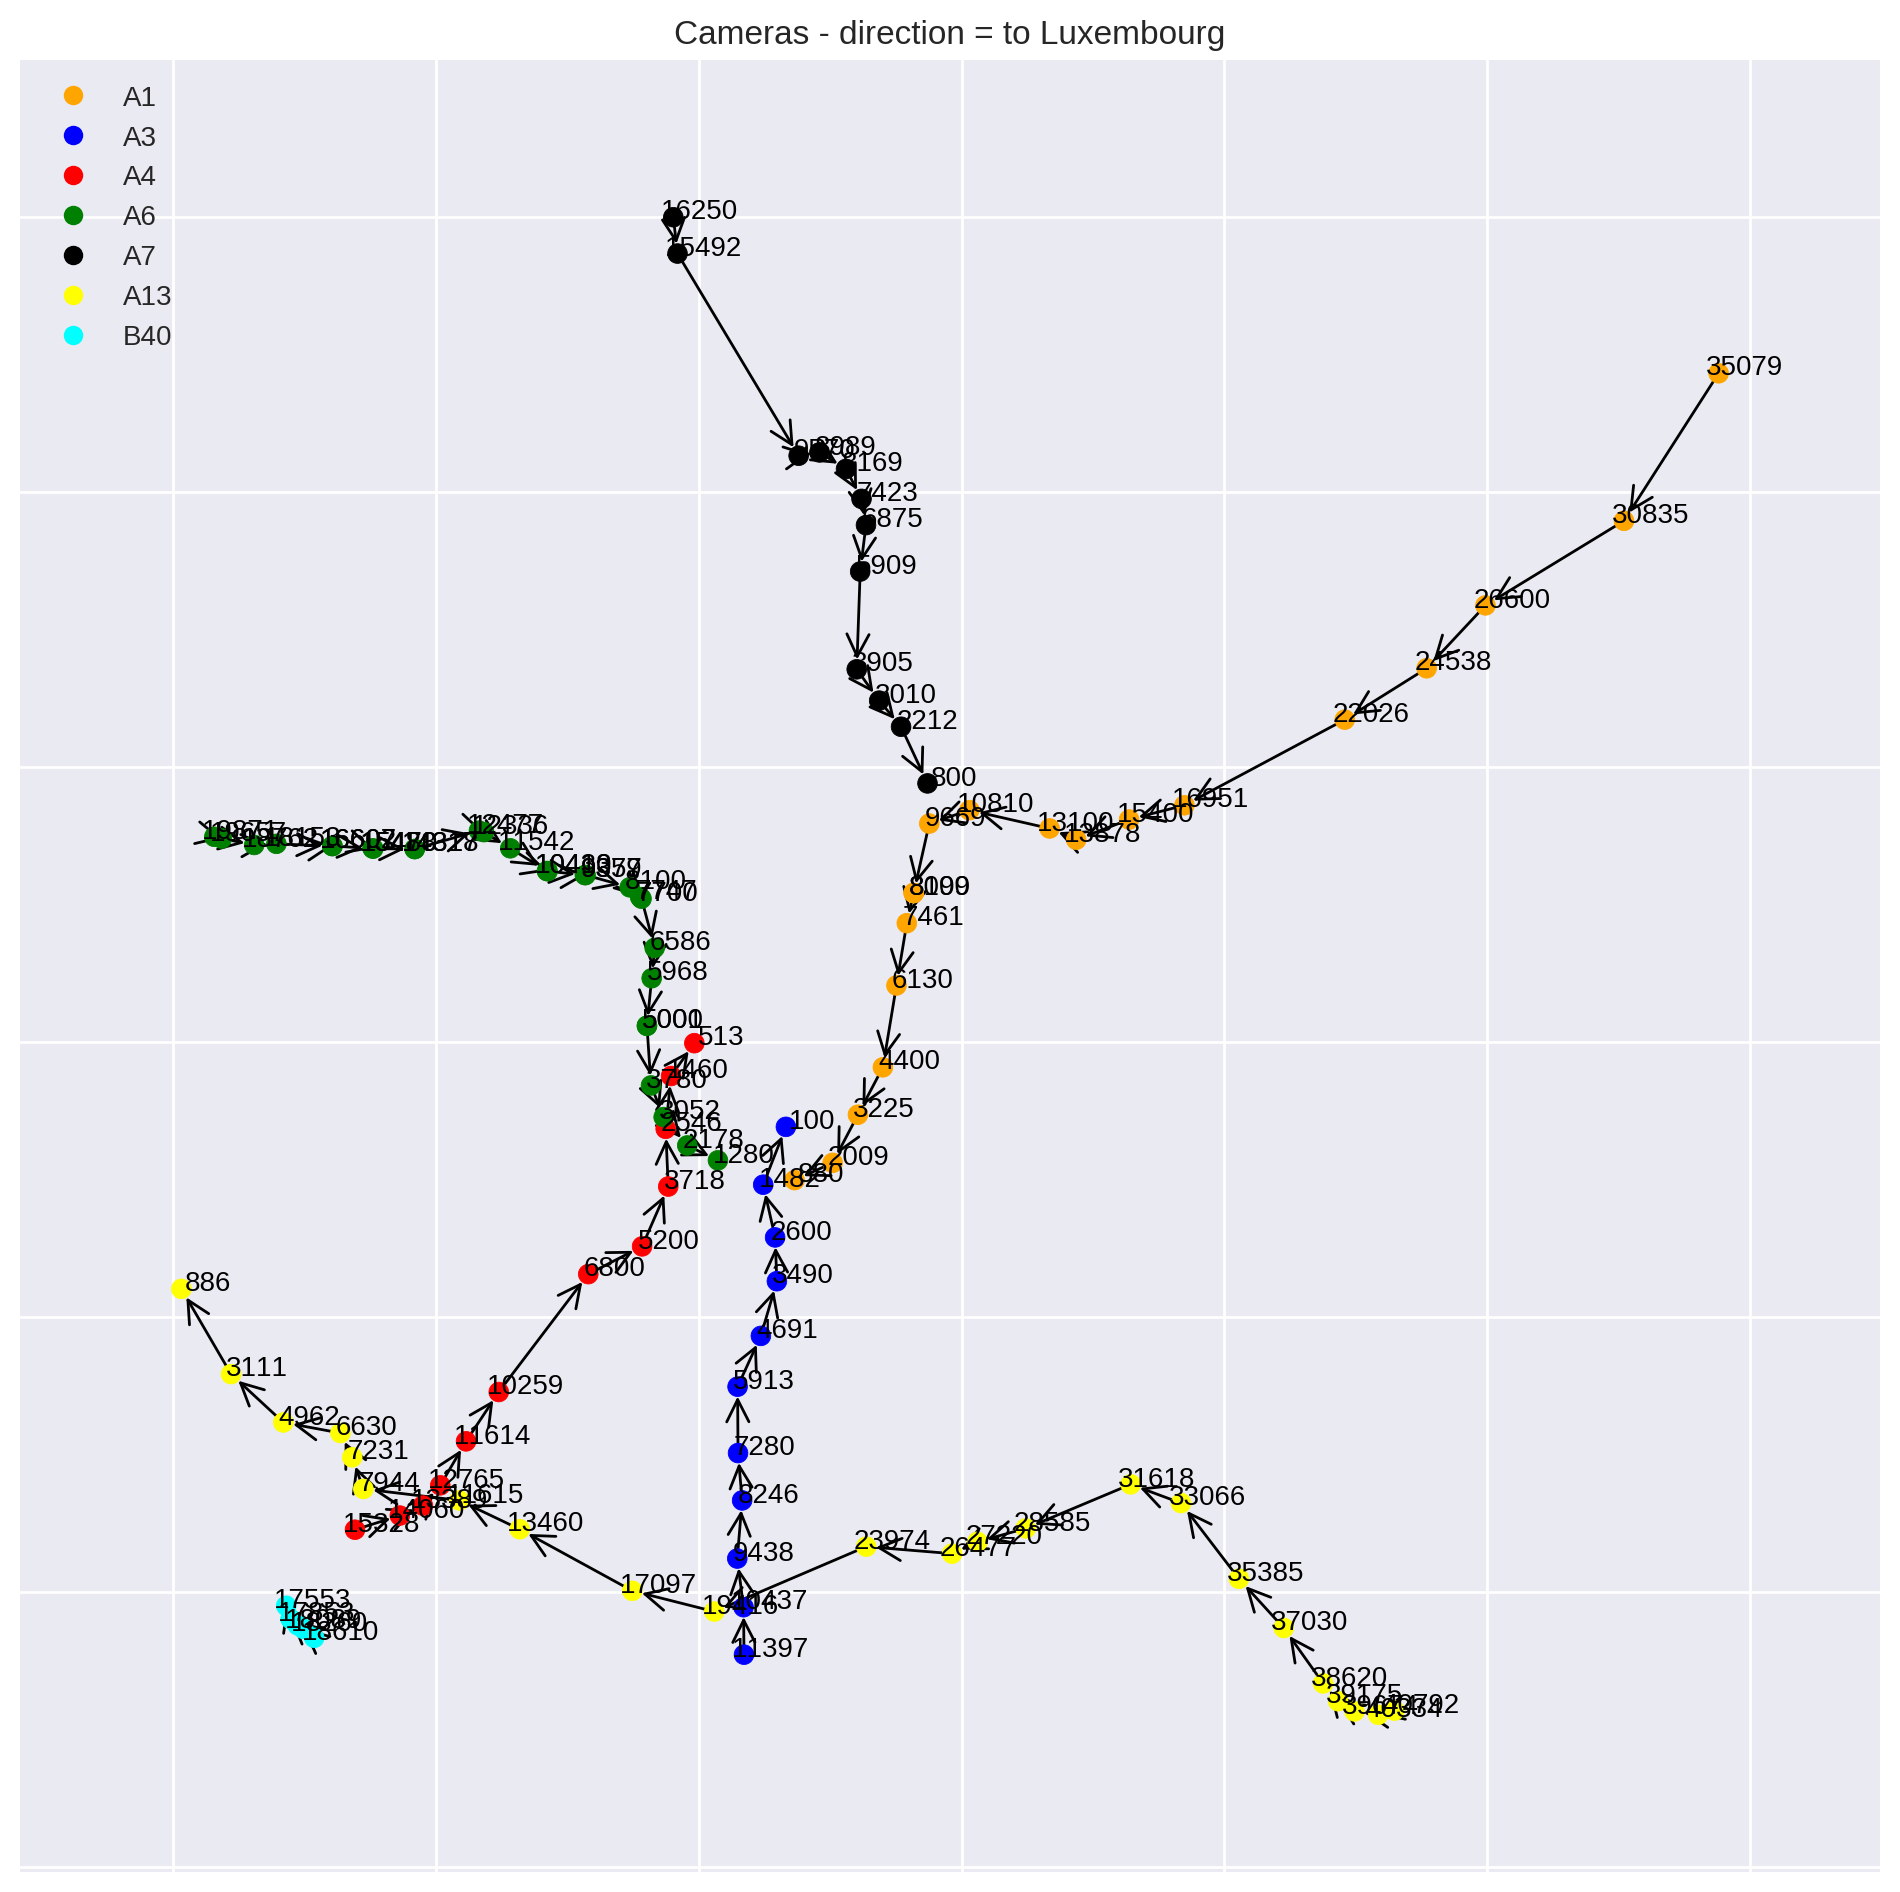

In [51]:
### we should get the dataframe camera to print the map
camera = getMapDf(raw_data)

# print the cameras map
GTo = getGraph(camera, direction="inboundTowardsTown")

#### this is the map from other places to Luxembourg
printMap(GTo, title="Cameras - direction = to Luxembourg")

- What we are interested in is the road A3 (the blue line) and the direction is to Luxembourg, and then we will focus on the camera 11397 and 10437 and analyze it. But the analysis of each road is actually the same.

## **Visualizing the raw data**


Show the simple plot of time series of the two cameras, but in order to see the graph more clearly, I just show the camera - 11397:

* show all the data(nearly one month of data)
* show one week of data
* show one day of data

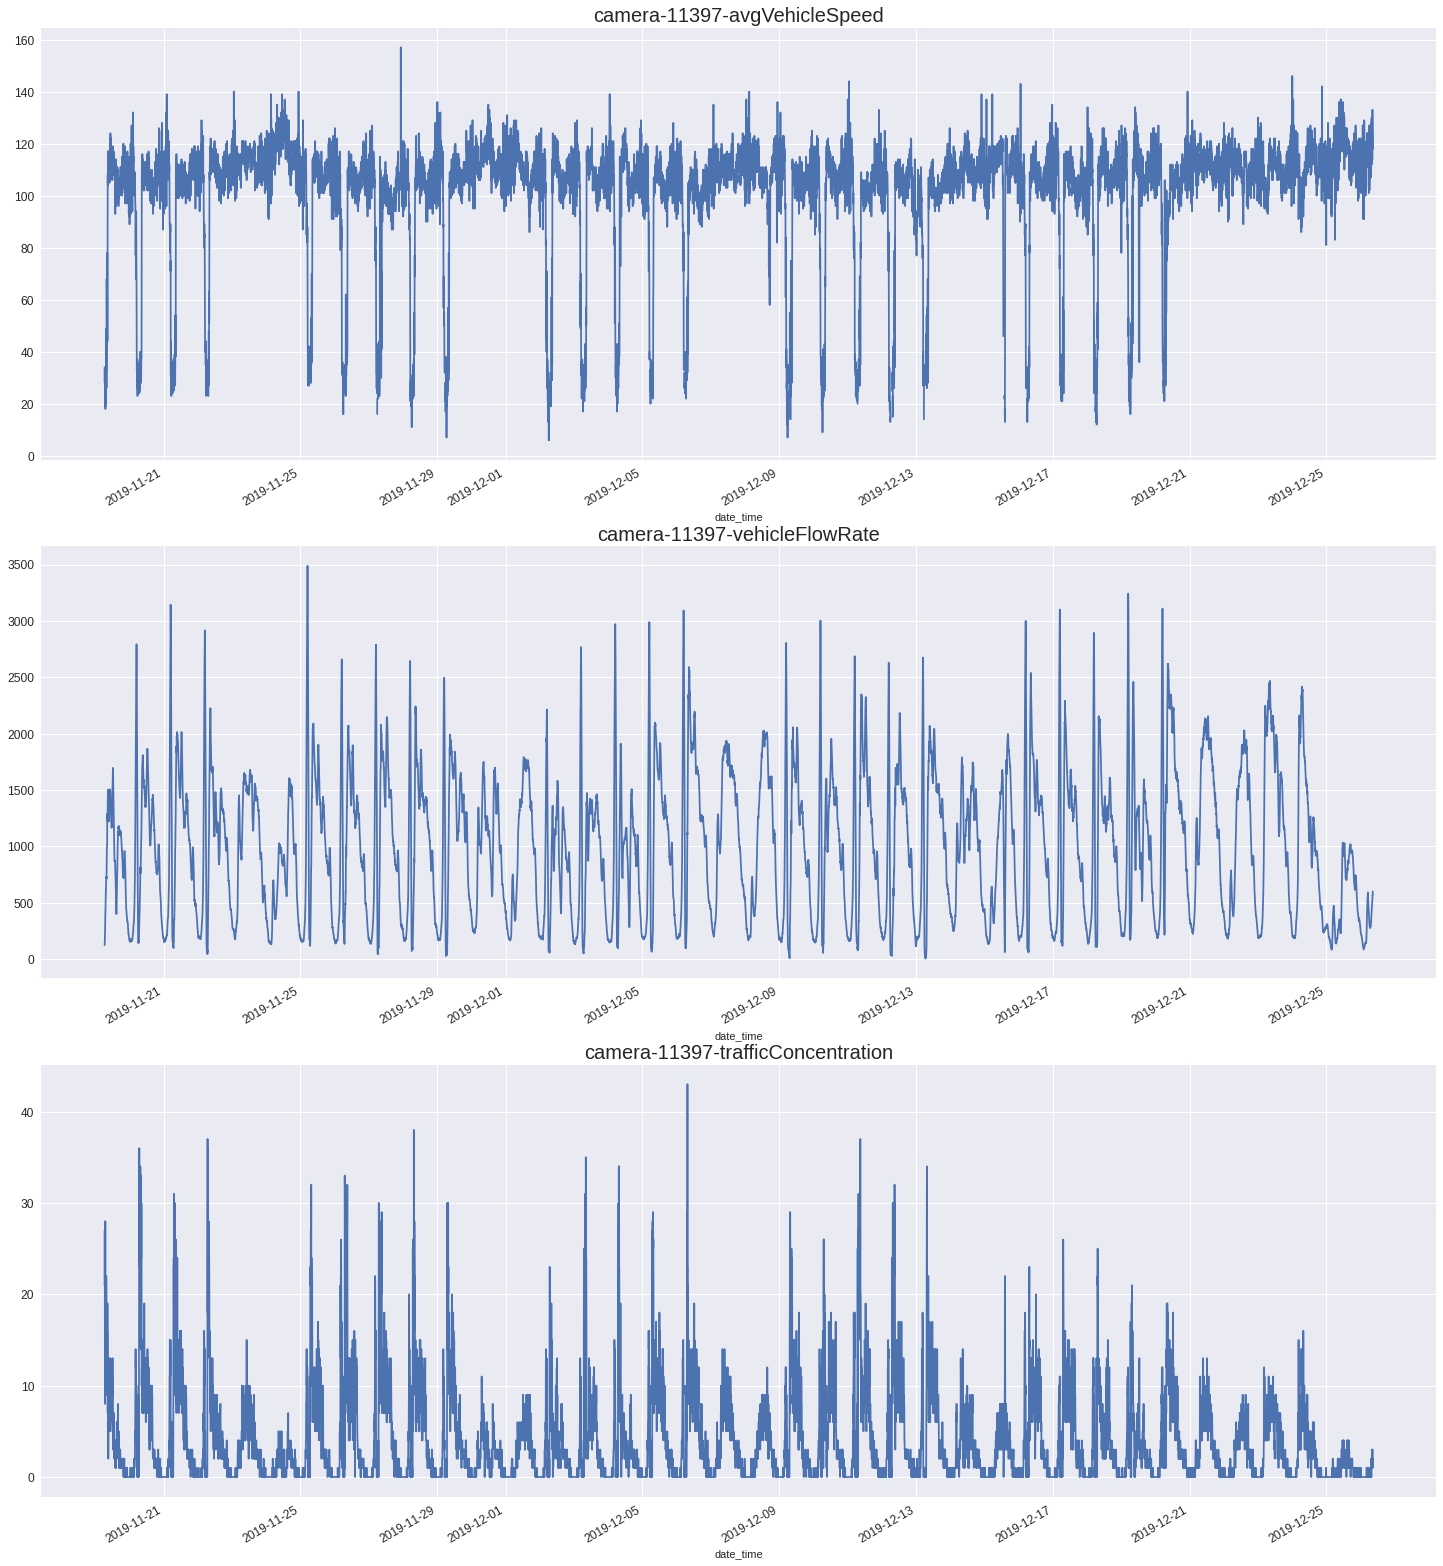

In [52]:
### get the two cameras dataframe 
id_camera = ['11397', '10437']
camera_data = getTheCameraData(raw_data, id_camera)

### Show all the data of camera 11397
plotTimeSeries(camera_data)

- All three attributes have a weekly periodicity. The values of weekdays and weekends are different, but you can see that when December 25 is approaching, although it is not a weekend, its value has also changed compared to before. Because everyone is basically reunited at home during Christmas, there will be fewer cars on the highway

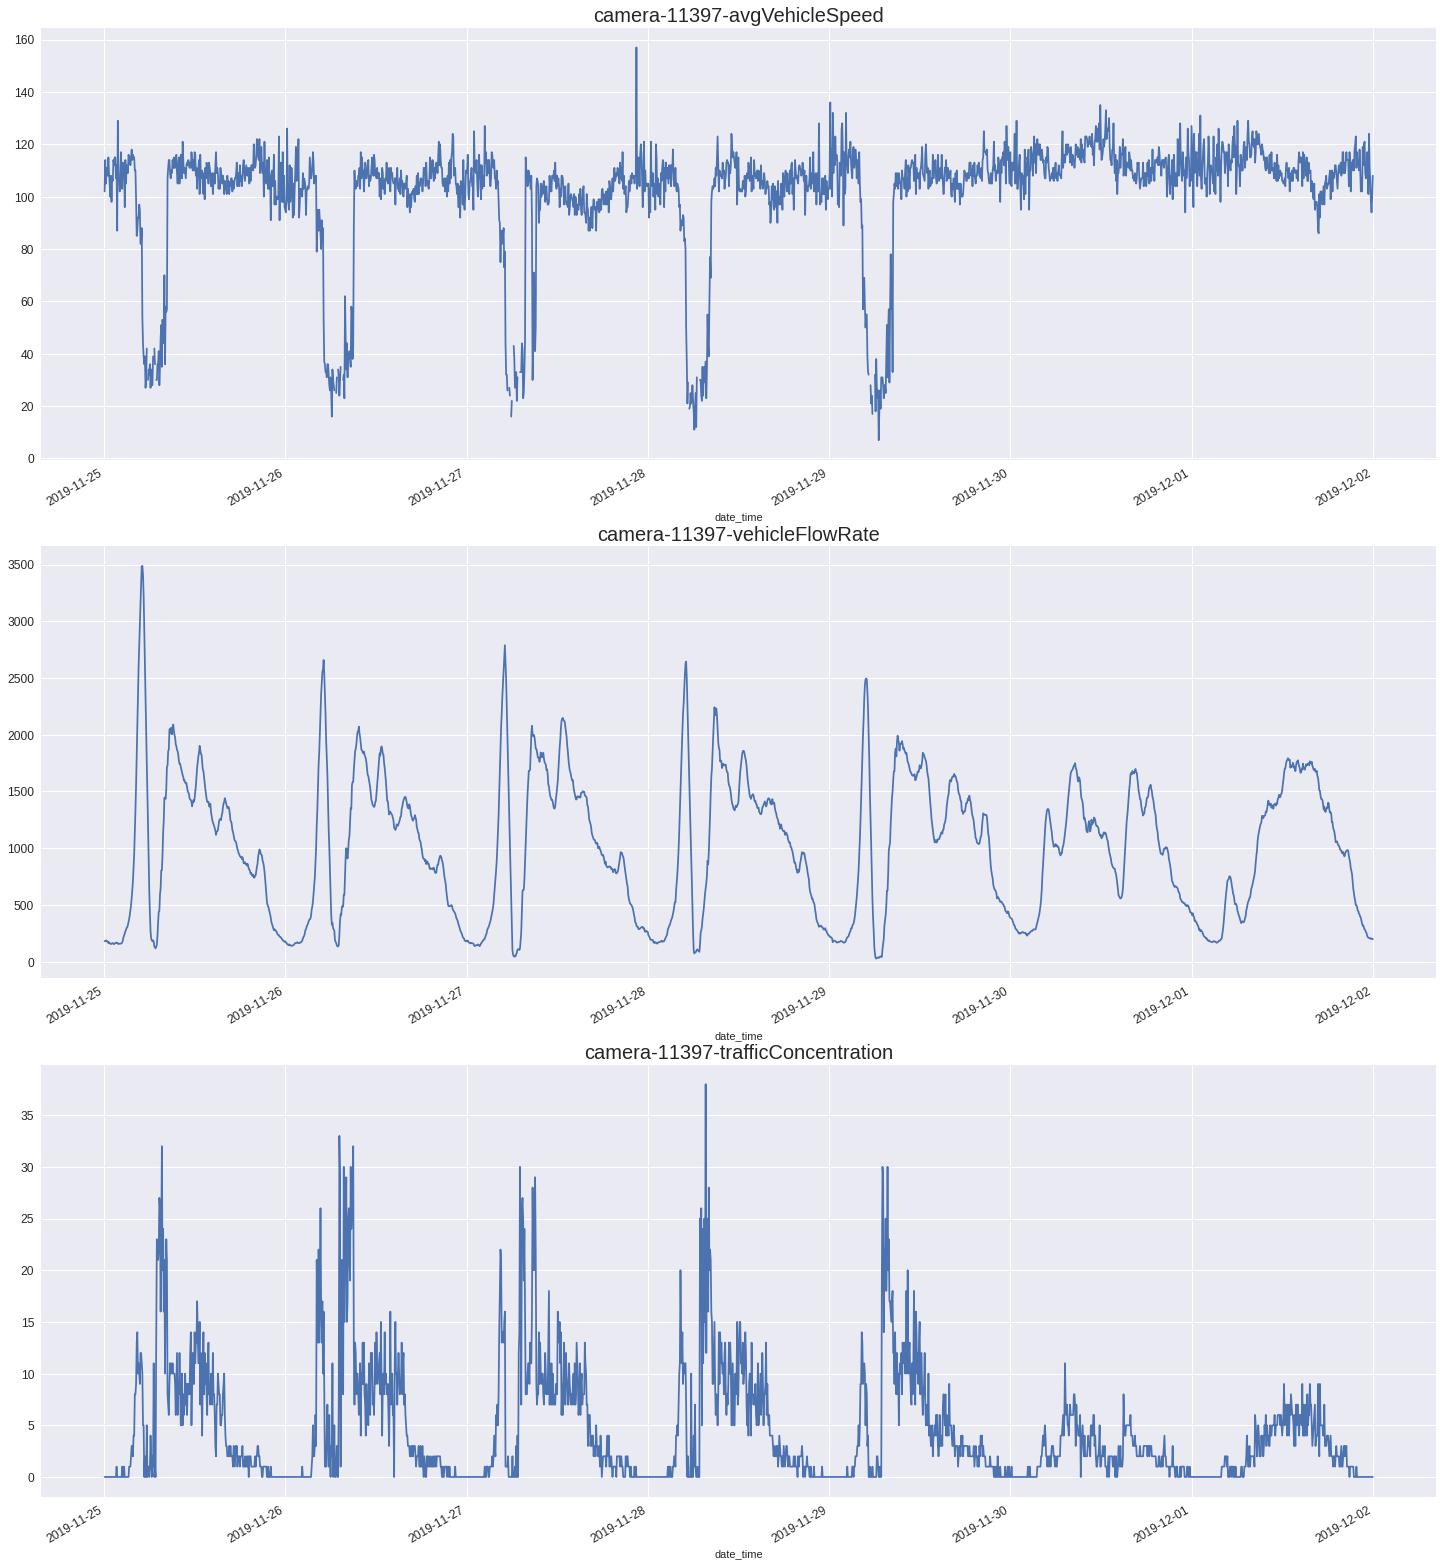

In [53]:
### Show one week of data
plotTimeSeries(camera_data, '2019-11-25 00:00:00+0000', '2019-12-02 00:00:00+0000')

In [54]:
camera_data.loc[(camera_data['date_time'] > '2019-12-25 00:00:00+00:00') & (camera_data['date_time'] < '2019-12-25 01:00:00+00:00')]['trafficConcentration']

date_time
2019-12-25 00:04:00+00:00    0.0
2019-12-25 00:04:00+00:00    0.0
2019-12-25 00:04:00+00:00    0.0
2019-12-25 00:04:00+00:00    0.0
2019-12-25 00:09:00+00:00    0.0
2019-12-25 00:09:00+00:00    0.0
2019-12-25 00:09:00+00:00    0.0
2019-12-25 00:09:00+00:00    0.0
2019-12-25 00:14:00+00:00    0.0
2019-12-25 00:14:00+00:00    0.0
2019-12-25 00:19:00+00:00    0.0
2019-12-25 00:19:00+00:00    0.0
2019-12-25 00:19:00+00:00    0.0
2019-12-25 00:19:00+00:00    0.0
2019-12-25 00:24:00+00:00    1.0
2019-12-25 00:24:00+00:00    0.0
2019-12-25 00:24:00+00:00    1.0
2019-12-25 00:24:00+00:00    0.0
2019-12-25 00:29:00+00:00    0.0
2019-12-25 00:29:00+00:00    1.0
2019-12-25 00:34:00+00:00    1.0
2019-12-25 00:34:00+00:00    0.0
2019-12-25 00:34:00+00:00    1.0
2019-12-25 00:34:00+00:00    0.0
2019-12-25 00:39:00+00:00    0.0
2019-12-25 00:39:00+00:00    0.0
2019-12-25 00:39:00+00:00    0.0
2019-12-25 00:39:00+00:00    0.0
2019-12-25 00:44:00+00:00    0.0
2019-12-25 00:44:00+00:00    0.0


- It can be clearly seen here that there is a daily periodicity and that the traffic volume and congestion on weekends are much smaller than those on weekdays. This is because some people who go to work in Luxembourg are resting at home

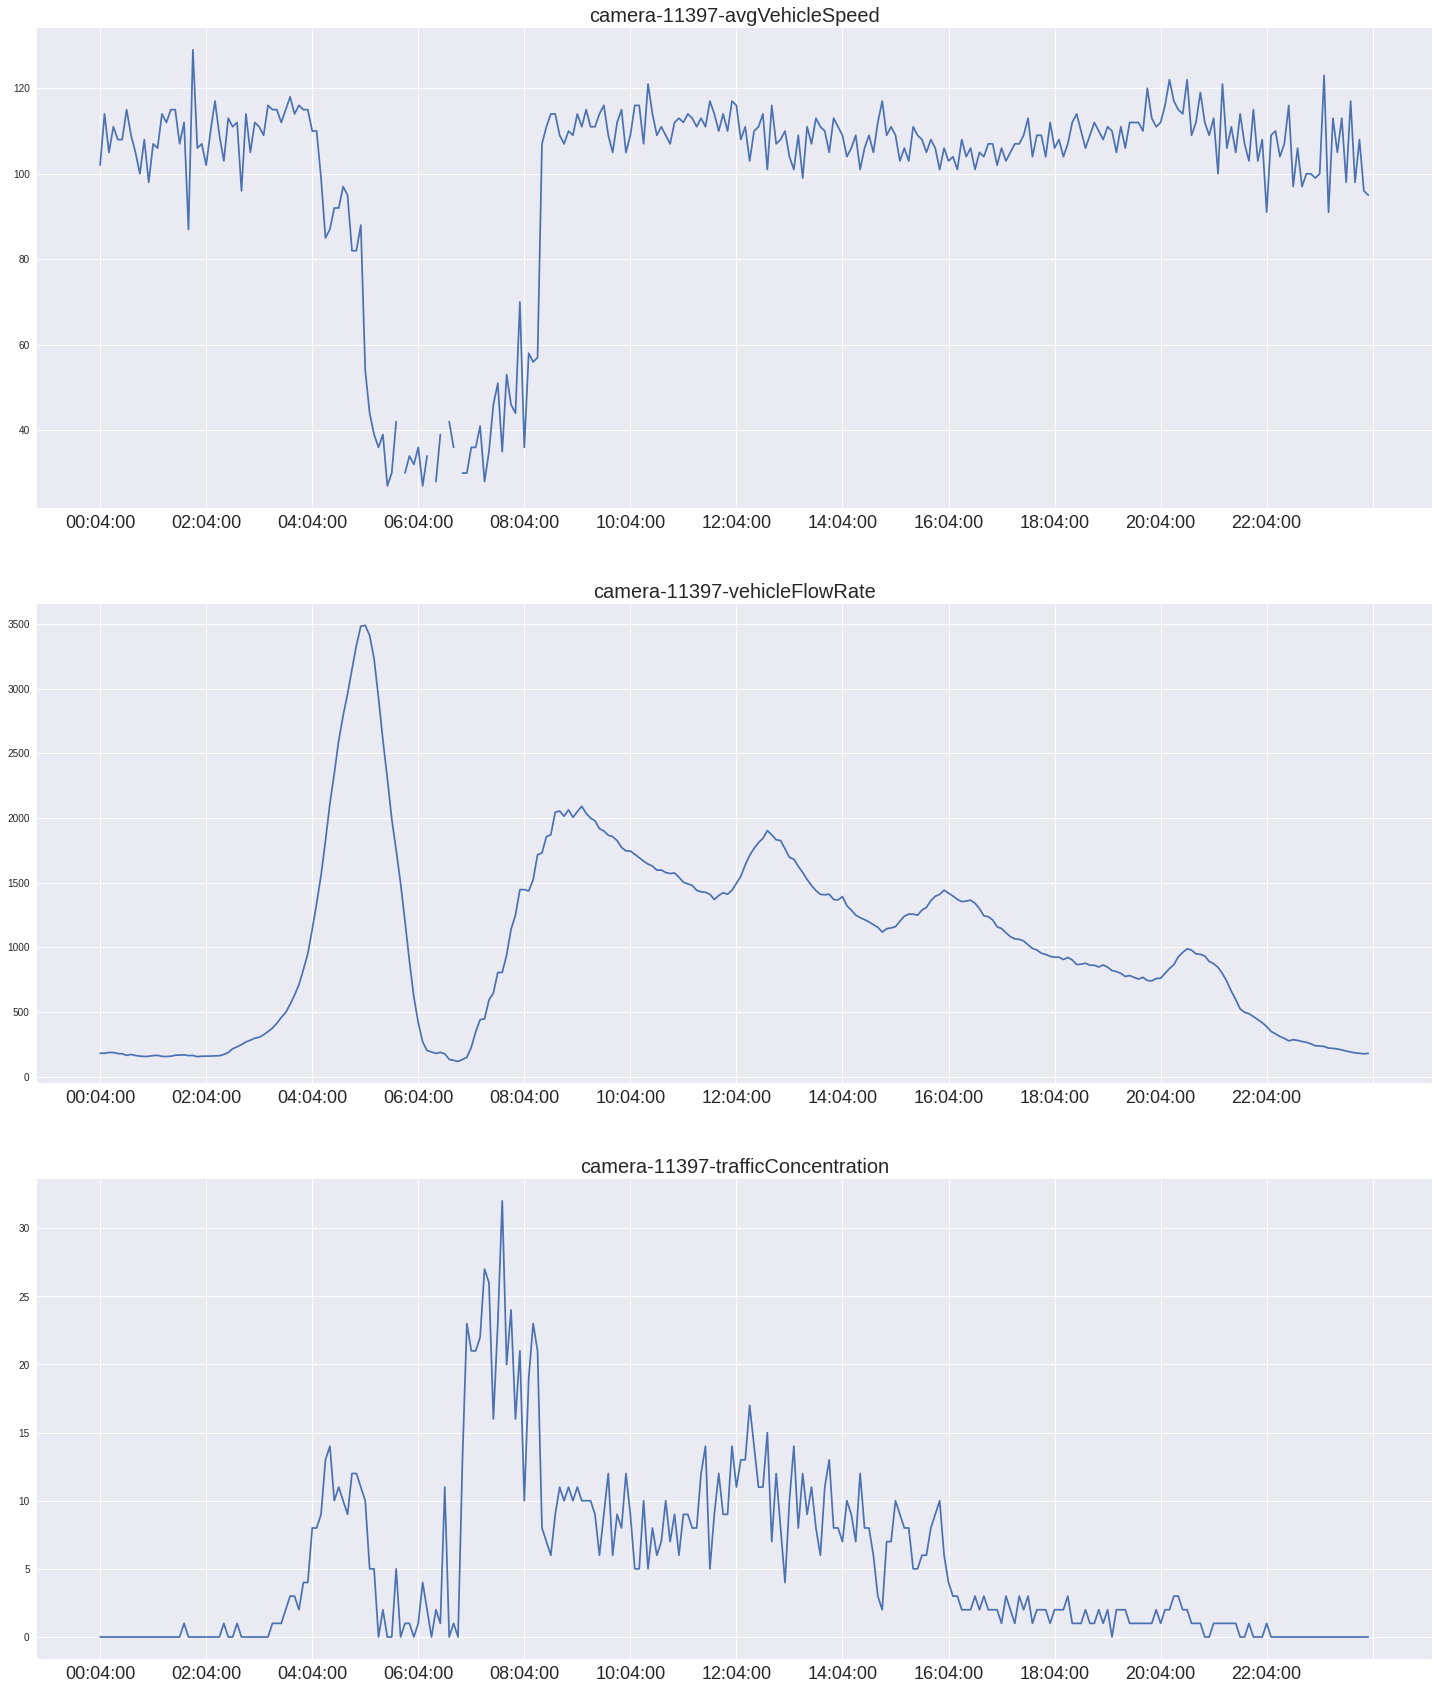

In [55]:
### Show one day of data
def plotTimeSeries(df, begin='2000-01-01 00:00:00+0000', end='2030-01-01 00:00:00'):
  camera_data = df[df.index > begin]
  camera_data = camera_data[camera_data.index < end]
  fig, ax = plt.subplots(3, 1, figsize=(25,30))
  ax = ax.flatten()
  id_camera = ['11397', '10437']
  cols = ['avgVehicleSpeed','vehicleFlowRate','trafficConcentration']
  i = 0
  id = '11397'
  df = camera_data.loc[camera_data['id'].str.contains(id)]
  for col in cols:
    ax[i].set_title("camera-" + id + "-" + col, fontsize=20)
    plt.axes(ax[i])
    plt.xticks(size=18)
    ax[i].set_xticks(range(0, 290, 24))
    plt.plot(df.index.strftime("%H:%M:%S"), df[col])
    i += 1
plotTimeSeries(camera_data, '2019-11-25 00:00:00+0000', '2019-11-26 00:00:00+0000')

- There are missing values in the record of average vehicle speed between 6 o'clock and 9 o'clock, but there is no problem with the record of traffic volume and traffic congestion. It means that the camera sensor that measures the speed of the car has a short-term problem

**Conclusion analysis**
- From the above figure, it can be seen that the missing values are not particularly obvious. After all, only 263 pieces of data (0.7%) are missing from the 35518 pieces of data.
- The graph of a week matches a small pattern in a month. Similarly, the graph of a day is also a small pattern of the graph of the week


## **Find the missing and null values**

In [56]:
### see the statistic of data and the number of null value
to_show = camera_data.copy()
describeData(to_show)

shape = (35518, 8)
                        count        mean         std  ...     75%     max  isNull
avgVehicleSpeed       35255.0  102.127103   22.097192  ...   113.0   157.0     263
vehicleFlowRate       35518.0  908.786869  581.233365  ...  1318.0  3489.0       0
trafficConcentration  35518.0    3.731939    4.398649  ...     5.0    43.0       0
dayofWeek             35518.0    2.934399    1.969051  ...     5.0     6.0       0
day                   35518.0   16.803086    8.287009  ...    24.0    30.0       0
hour                  35518.0   11.490174    6.919827  ...    17.0    23.0       0

[6 rows x 9 columns]


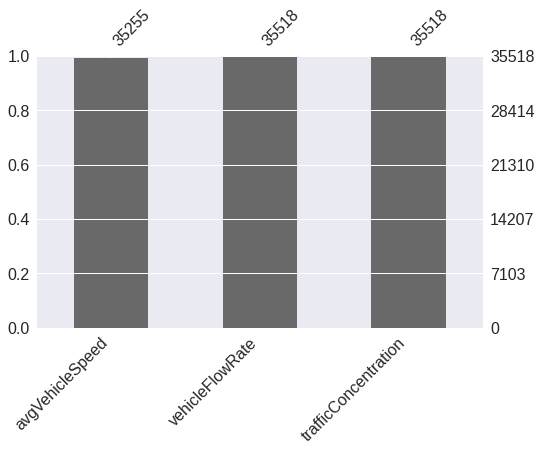

In [57]:
msno.bar(to_show[['avgVehicleSpeed', 'vehicleFlowRate', 'trafficConcentration']], figsize=(8,5))
plt.show()

In [58]:
### find all the null values (missing values by day)
theMostNullValue(to_show)

the date 11-19 has 1 null value data
the date 11-20 has 8 null value data
the date 11-21 has 8 null value data
the date 11-22 has 10 null value data
the date 11-24 has 2 null value data
the date 11-25 has 9 null value data
the date 11-26 has 18 null value data
the date 11-27 has 14 null value data
the date 11-28 has 7 null value data
the date 11-29 has 9 null value data
the date 12-02 has 9 null value data
the date 12-03 has 13 null value data
the date 12-05 has 12 null value data
the date 12-06 has 6 null value data
the date 12-09 has 24 null value data
the date 12-10 has 6 null value data
the date 12-11 has 18 null value data
the date 12-12 has 32 null value data
the date 12-13 has 27 null value data
the date 12-15 has 9 null value data
the date 12-16 has 8 null value data
the date 12-17 has 1 null value data
the date 12-18 has 9 null value data
the date 12-19 has 1 null value data
the date 12-26 has 2 null value data
---------------------------------
the date 12-12 has the most null

- There are the most missing values near December 12th, so we can see exactly when the missing values these days are

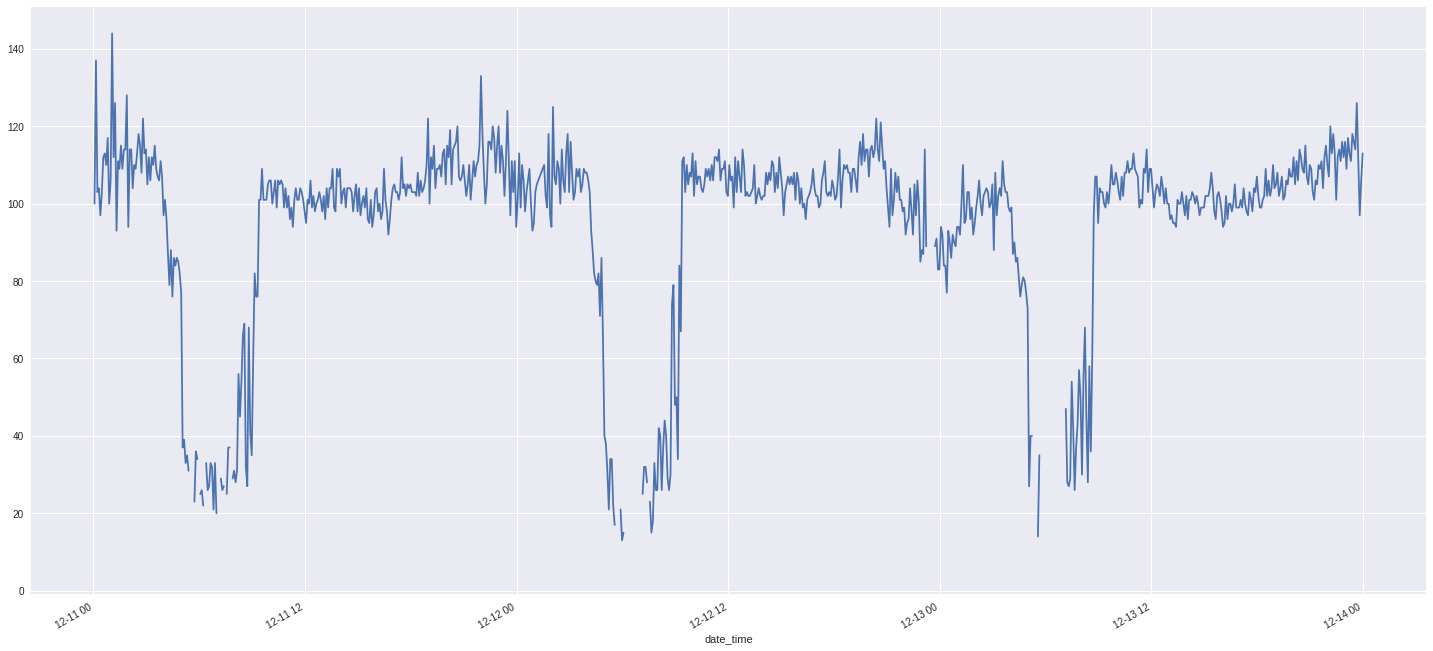

In [59]:
### So I have a look at the day December 11th, December 12th and December 13th
cd = camera_data.loc[camera_data['id'].str.contains('11397')]
cd = cd.loc[cd.index > '2019-12-11 00:00:00+0000']
cd = cd.loc[cd.index < '2019-12-14 00:00:00+0000']
fig, ax = plt.subplots(figsize=(25,12))
cd['avgVehicleSpeed'].plot()
plt.show()

- We can find that the camera is missing some values in the same time period (around 5-8 am) in these three days. This is very strange, are all missing values in this time period?

In [60]:
### let's see the specific time(in hours)
theMostNullValue(to_show, False)

the date 11-19 07h has 1 null value data
the date 11-20 06h has 6 null value data
the date 11-20 07h has 2 null value data
the date 11-21 00h has 2 null value data
the date 11-21 05h has 2 null value data
the date 11-21 06h has 3 null value data
the date 11-21 23h has 1 null value data
the date 11-22 05h has 2 null value data
the date 11-22 06h has 8 null value data
the date 11-24 02h has 2 null value data
the date 11-25 01h has 2 null value data
the date 11-25 05h has 1 null value data
the date 11-25 06h has 6 null value data
the date 11-26 06h has 6 null value data
the date 11-26 07h has 8 null value data
the date 11-26 14h has 4 null value data
the date 11-27 05h has 5 null value data
the date 11-27 06h has 8 null value data
the date 11-27 07h has 1 null value data
the date 11-28 05h has 2 null value data
the date 11-28 06h has 5 null value data
the date 11-29 05h has 7 null value data
the date 11-29 06h has 1 null value data
the date 11-29 07h has 1 null value data
the date 12-02 0

- It seems that this camera has periodic problems. It seems that problems often occur at 5-8 in the morning without recording data.





### **Filling the null value, replacing them with the previous value**

In [61]:
dd = camera_data.copy()
### Check the number of duplicate values(it means that there are two different values in one date. Maybe it has such a situation, maybe it doesn't
### Do it in advance, if it doesn't have duplicate values it affect nothing)
data = fillNull(dd)
data.set_index(['id', 'date_time'], drop = False, inplace = True)
nan_num = data.index.duplicated().sum()
print(f"the number of duplicate value is {nan_num}")

### process the raw data filling the null values and delete de duplicate values
data = fillTheNull(data)

the number of duplicate value is 14192


In [62]:
### show the data after filling
describeData(data)

shape = (21326, 8)
                        count        mean         std  ...     75%     max  isNull
avgVehicleSpeed       21326.0  101.614649   22.810283  ...   113.0   157.0       0
vehicleFlowRate       21326.0  908.914658  581.191052  ...  1318.0  3489.0       0
trafficConcentration  21326.0    3.737550    4.398359  ...     5.0    43.0       0
dayofWeek             21326.0    2.933977    1.969034  ...     5.0     6.0       0
day                   21326.0   16.804370    8.285763  ...    24.0    30.0       0
hour                  21326.0   11.493763    6.918906  ...    17.0    23.0       0

[6 rows x 9 columns]


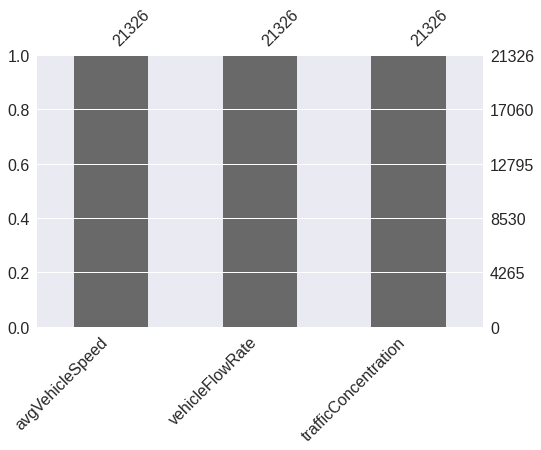

In [63]:
msno.bar(data[['avgVehicleSpeed', 'vehicleFlowRate', 'trafficConcentration']], figsize=(8,5))
plt.show()

- here is not null values, good

## **Visualize the data of ```avgVehicleSpeed``` over time after filling null values.**

We choose this variable because other two variables have no null values in the previous.

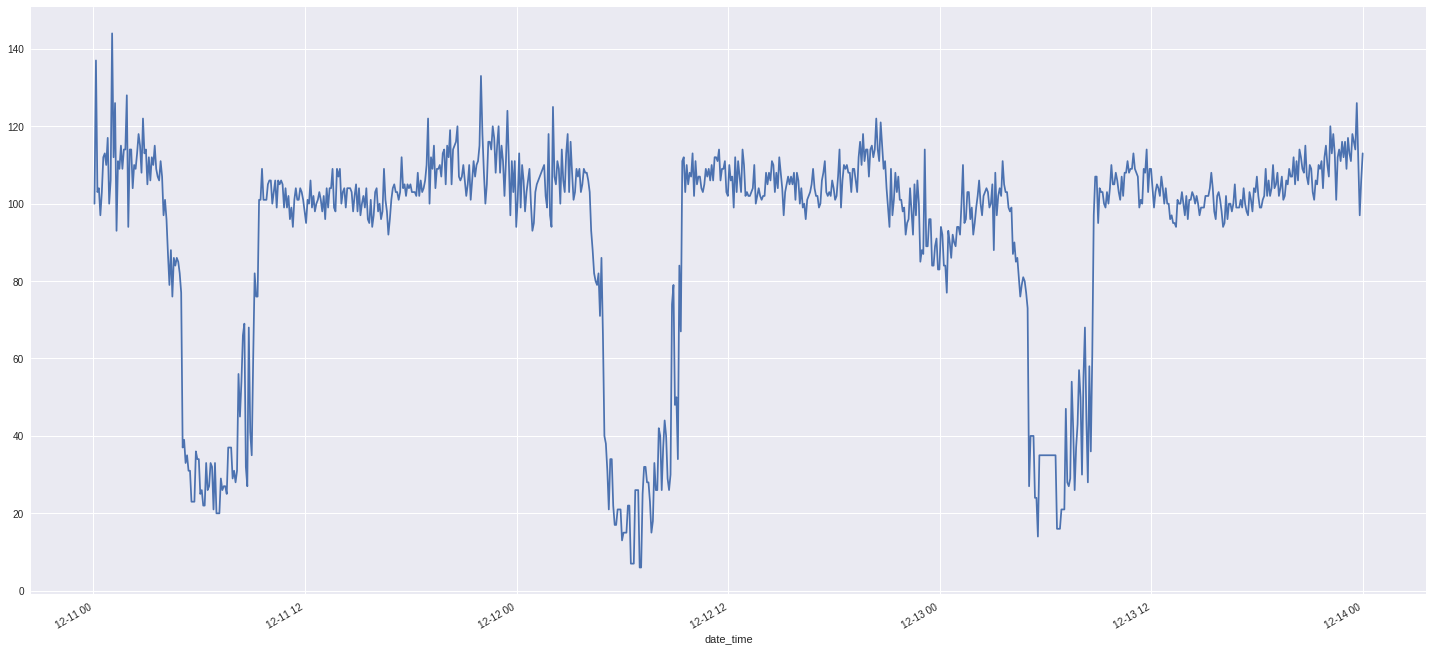

In [64]:
### Check the time period when the previous value is null values
cd = data.loc[data['id'].str.contains('11397')]
cd = cd.loc[cd.index > '2019-12-11 00:00:00+0000']
cd = cd.loc[cd.index < '2019-12-14 00:00:00+0000']
fig, ax = plt.subplots(figsize=(25,12))
cd['avgVehicleSpeed'].plot()
plt.show()

- It can be seen that the missing value no longer exists, let's do next.


### **Observing the similarity between the two cameras of highway A3**




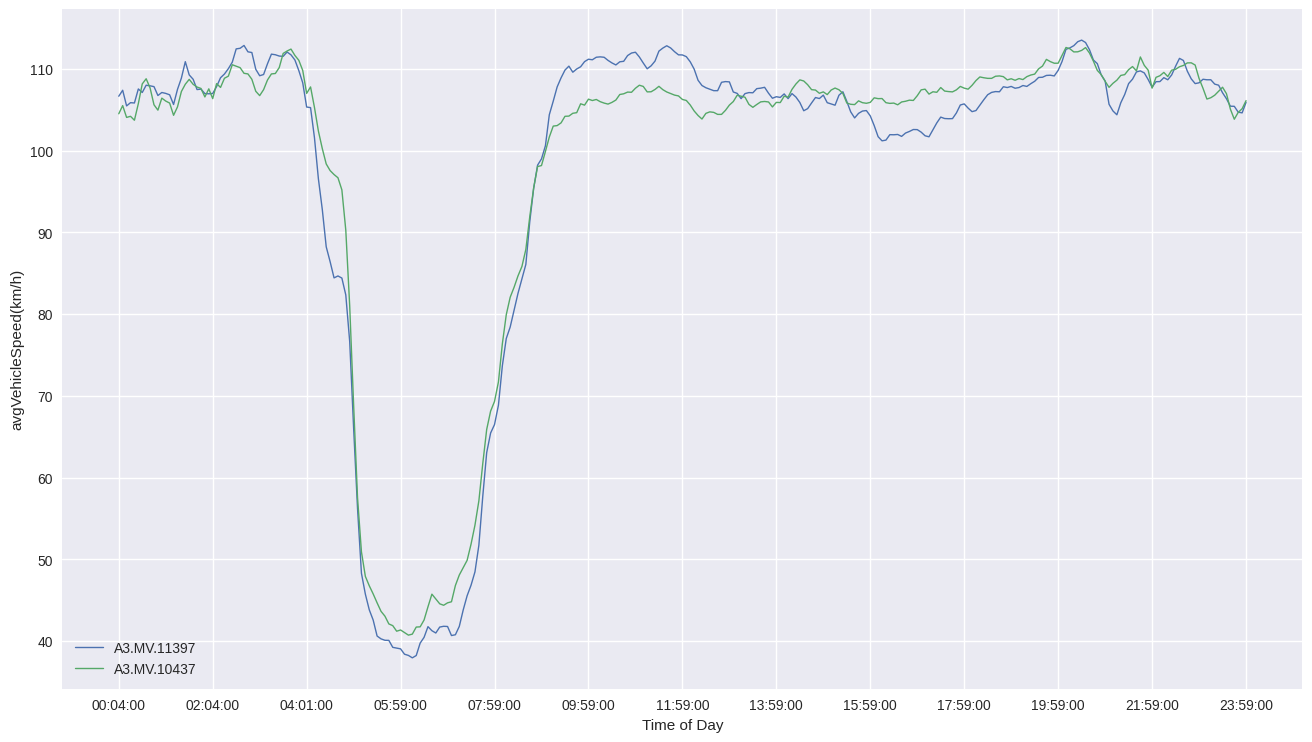

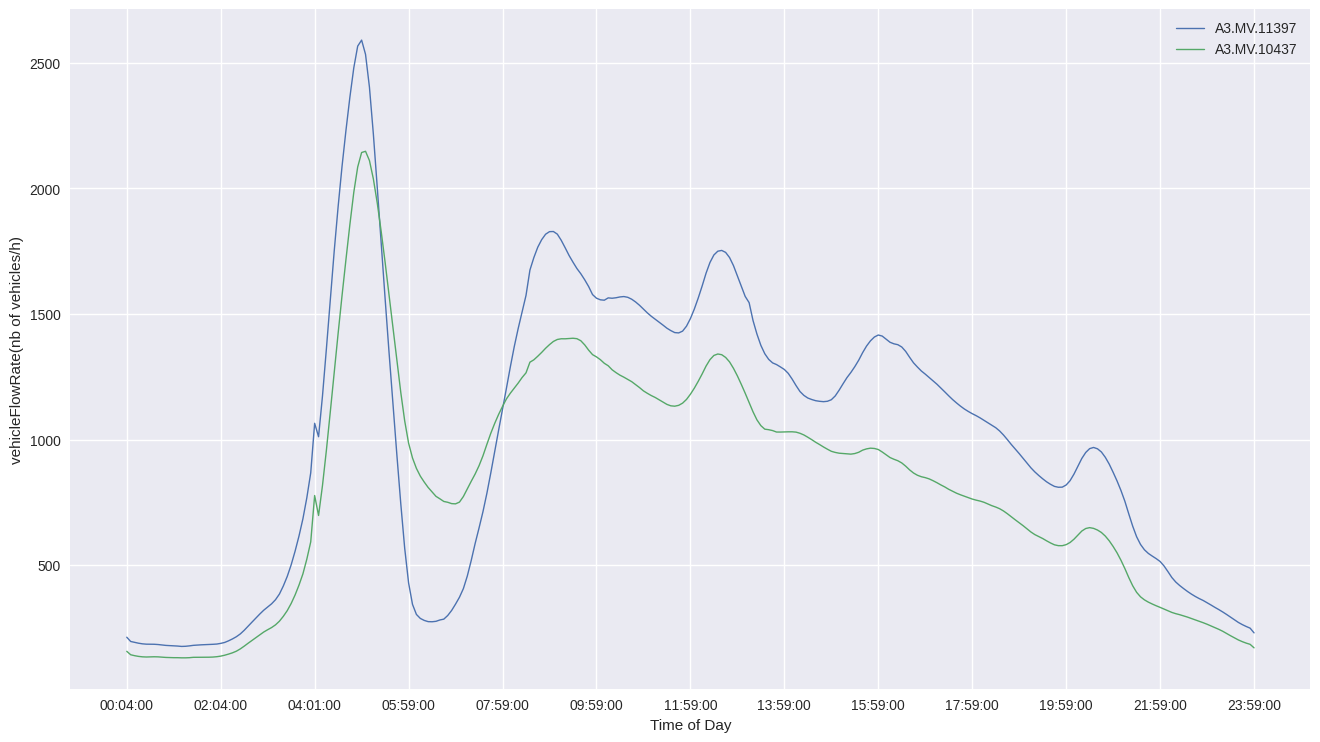

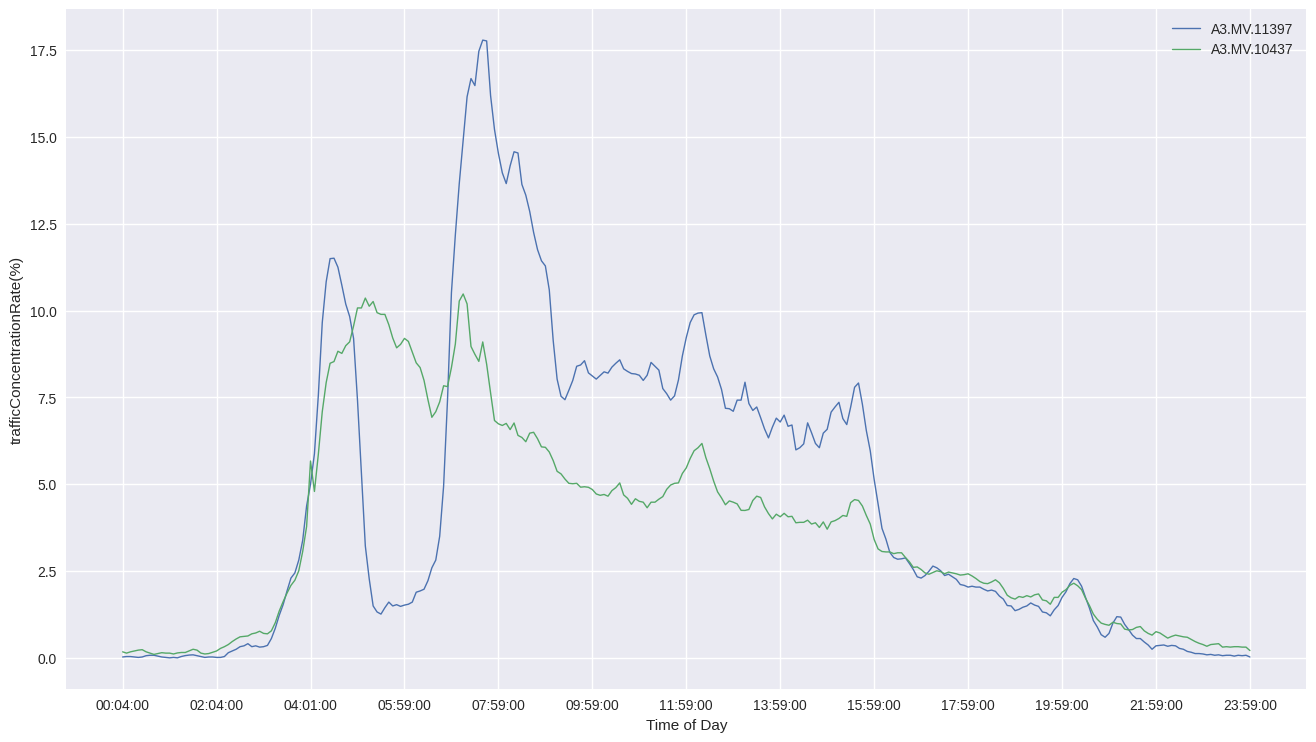

In [65]:
### put the two camera together to see more clear
plotTheSimilarity(data)

**Conclusion analysis**
- The trend of data obtained by cameras approaching at the same time is similar. And here it can be clearly seen that the image trend of 10437 is later than that of 11397
- And the greater the traffic congestion, the smaller the closeness between the two values (the overall trend is still similar)

### **Statistical analysis of data**


In [101]:
### show the std of all three values in two cameras
data1 = data.loc[data.id.str.contains('11397')]
print(f"the std of avgVehicleSpeed in camera 11397 is {np.std(data1['avgVehicleSpeed'])}")
print(f"the std of vehicleFlowRate in camera 11397 is {np.std(data1['vehicleFlowRate'])}")
print(f"the std of trafficConcentration in camera 11397 is {np.std(data1['trafficConcentration'])}")
data2 = data.loc[data.id.str.contains('10437')]
print(f"the std of avgVehicleSpeed in camera 10437 is {np.std(data2['avgVehicleSpeed'])}")
print(f"the std of vehicleFlowRate in camera 10437 is {np.std(data2['vehicleFlowRate'])}")
print(f"the std of trafficConcentration in camera 10437 is {np.std(data2['trafficConcentration'])}")

the std of avgVehicleSpeed in camera 11397 is 23.47843492217834
the std of vehicleFlowRate in camera 11397 is 634.2091998200012
the std of trafficConcentration in camera 11397 is 5.160525076719743
the std of avgVehicleSpeed in camera 10437 is 22.120856112830715
the std of vehicleFlowRate in camera 10437 is 506.06912127725514
the std of trafficConcentration in camera 10437 is 3.431463317786181


- Then we observe the correlation among the ```avgVehicleSpeed, VehicleFlowRate, trafficConcentration```.

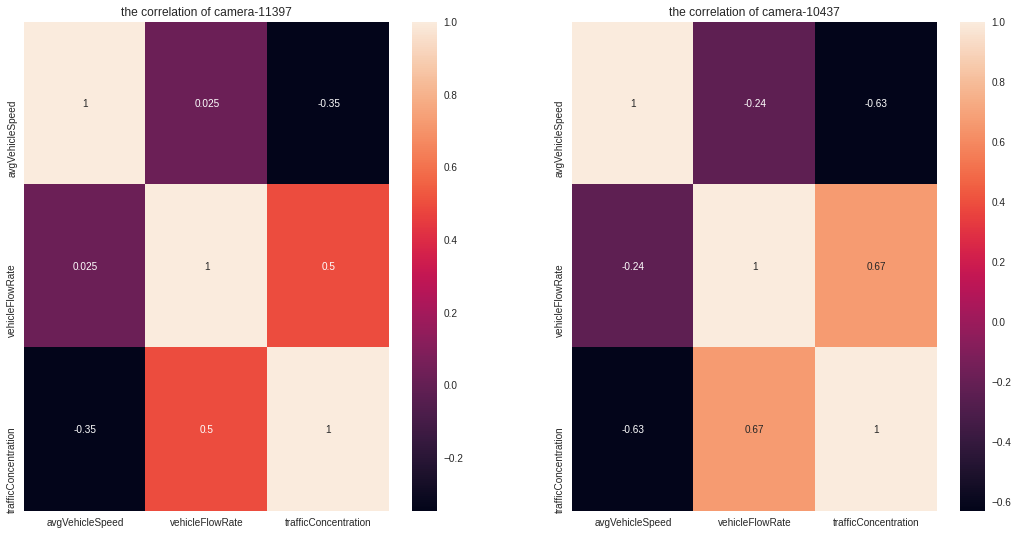

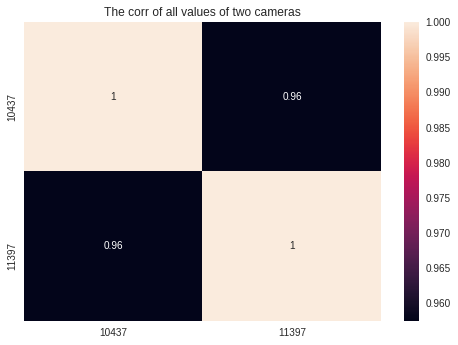

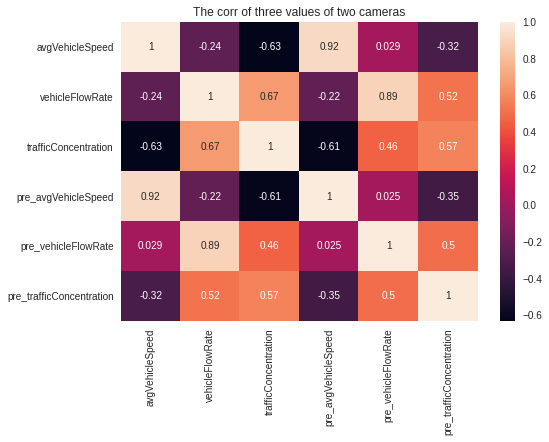

In [102]:
### Get their respective correlations
fig, ax = plt.subplots(1,2, figsize=(18, 9))
getTheCorrelationOf(data, '11397', ax[0])
getTheCorrelationOf(data, '10437', ax[1])

### Get the correlation of the two cameras
getTheMapCorrOfTwoCamera(data, '10437', '11397', ['avgVehicleSpeed', 'vehicleFlowRate', 'trafficConcentration'])
plt.show()
getTheMapCorrOfTwoCamera(data, '10437', '11397', ['avgVehicleSpeed', 'vehicleFlowRate', 'trafficConcentration'], False)

**Conclusion analysis**
- Generally speaking, vehicle speed is negatively related to traffic flow and traffic congestion. That is, the more cars, the slower the speed
- The direct correlation coefficient of these two cameras is close to 1, so they have a high degree of correlation, which also provides a guarantee for our model use in the future.
- We can try to predict the value ```avgVehicleSpeed``` and ```vehicleFlowRate``` of camera-10437 by the value for a certain period of time in the past of itself and the value ```avgVehicleSpeed``` and ```vehicleFlowRate``` of the previous camera-11397
- Maybe we can also try to predict the value ```vehicleFlowRate``` and ```trafficConcentration``` of camera-10437 totally by the three features ```['avgVehicleSpeed', 'vehicleFlowRate', 'trafficConcentration'] ``` of the previous camera-11397




## **Time serie forecasting**

Now we will use the models to do time serie forecasting. There are two models I will use -- LSTM and VAR.

The features of two models I have already introduced before. So I will use the LSTM firstly.


## **LSTM** 
One kind of the RNN, with long-term memory function, it makes up for the short-term memory shortcomings of traditional RNN

The following are the steps for LSTM:

- Build a LSTM model and use the train set to fit the model
- Make a prediction and calcule RMSE
- Try to change some parameters to improve the model


### **Use the data of two camera to make prediction**
To explore the relation between the two cameras(sensors), as we can see in the correlation matrix the avgVehicleSpeed and vehicleFlowRate has high correlation. 

Here firstly, I use the past 10(value of WINDOW) * 5(time of data interval)  minutes to predict the future 5, 10, and 15 minutes of data.

**The window has 10 steps in past and 3 steps to predict**

```WINDOW = 10```

```FORECAST = 3```

- IN:

  The Features IN are composed of 4 series :
  - avgVehicleSpeed of the camera-10437
  - vehicleFlowRate of the camera-10437
  - avgVehicleSpeed of the previous camera-11397 (previous)
  - vehicleFlowRate of the previous camera-11397 (previous)
- OUT :

  - target feature : average speed and vehicleFlowRate of camera-10437

FORECAST = 1 (+5 minutes), 2 (+10 minutes) or 3 (+15 minutes)




In [68]:
### choose the camera-10437 and its previous camera-11397
cam = 'A3.MV.10437' 
cam1 = 'A3.MV.11397'

### WINDOW means backward, FORECAST means forward
WINDOW = 10
FORECAST = 3

build the dataframe that we will use to get the special sequence input for model LSTM

In [69]:
### build the feature frame, The function of buildTheFeature1 is to take out the data corresponding to the two cameras, 
### and then use the join method to merge the data, the column name corresponding to camera-11397 with the prefix "pre"
df = buildTheFeature1(data, cam, cam1)
### have a look at the df
df.head()

avgVehicleSpeed  ...  pre_vehicleFlowRate
date_time                                   ...                     
2019-11-19 06:39:00+00:00             37.0  ...                  124
2019-11-19 06:44:00+00:00             30.0  ...                  139
2019-11-19 06:49:00+00:00             35.0  ...                  185
2019-11-19 06:54:00+00:00             34.0  ...                  230
2019-11-19 06:59:00+00:00             35.0  ...                  271

[5 rows x 4 columns]

In [70]:
### Numbers are normalized to 0-1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled

array([[0.20689655, 0.23380384, 0.18543046, 0.03415614],
       [0.15862069, 0.21027868, 0.14569536, 0.03846154],
       [0.19310345, 0.22982266, 0.17880795, 0.05166475],
       ...,
       [0.75172414, 0.16250452, 0.79470199, 0.16216992],
       [0.75172414, 0.1664857 , 0.74172185, 0.16188289],
       [0.70344828, 0.17661962, 0.74172185, 0.17078071]])

In [71]:
### get the input and the output, in the model LSTM, the input has three dimensions[samples, timesteps, features], the function
### getSequences divide the time series into n samples, the shape of each sample is the number of features of the dimension x data required 
### in the forward direction, so output is the data for train and the data as the result of training data.
X, _ = getSequences(scaled, backward = WINDOW , forward= FORECAST )
_ , ySpeed = getSequences(scaled[:,0], backward = WINDOW , forward= FORECAST )
_ , yFlow = getSequences(scaled[:,1], backward = WINDOW , forward= FORECAST )
### show the shape of the sequences
print(X.shape, ySpeed.shape, yFlow.shape)

(10651, 10, 4) (10651, 3) (10651, 3)


In [72]:
print(ySpeed[:10,:])
X[:10,:]

[[0.16551724 0.28275862 0.2137931 ]
 [0.28275862 0.2137931  0.19310345]
 [0.2137931  0.19310345 0.24827586]
 [0.19310345 0.24827586 0.25517241]
 [0.24827586 0.25517241 0.37241379]
 [0.25517241 0.37241379 0.57931034]
 [0.37241379 0.57931034 0.28965517]
 [0.57931034 0.28965517 0.46206897]
 [0.28965517 0.46206897 0.31034483]
 [0.46206897 0.31034483 0.62758621]]


array([[[0.20689655, 0.23380384, 0.18543046, 0.03415614],
        [0.15862069, 0.21027868, 0.14569536, 0.03846154],
        [0.19310345, 0.22982266, 0.17880795, 0.05166475],
        [0.1862069 , 0.21027868, 0.09271523, 0.06458094],
        [0.19310345, 0.24104235, 0.1589404 , 0.07634902],
        [0.22068966, 0.27832067, 0.08609272, 0.08897819],
        [0.13793103, 0.29315961, 0.12582781, 0.11768083],
        [0.28275862, 0.28013029, 0.0794702 , 0.11768083],
        [0.19310345, 0.32537097, 0.18543046, 0.13920781],
        [0.16551724, 0.35613464, 0.17880795, 0.16216992]],

       [[0.15862069, 0.21027868, 0.14569536, 0.03846154],
        [0.19310345, 0.22982266, 0.17880795, 0.05166475],
        [0.1862069 , 0.21027868, 0.09271523, 0.06458094],
        [0.19310345, 0.24104235, 0.1589404 , 0.07634902],
        [0.22068966, 0.27832067, 0.08609272, 0.08897819],
        [0.13793103, 0.29315961, 0.12582781, 0.11768083],
        [0.28275862, 0.28013029, 0.0794702 , 0.11768083],
        [0.1

### **Split input and output to the train set and test set**
- It is worth noting here that we are dealing with time series, so we cannot select randomly when selecting the training set and the test set.

In [73]:
### Select the first 70% of the data as the training set
nb_train = math.floor(X.shape[0] * 0.7)
X_train = X[:nb_train] #7455, 10,4
X_test = X[nb_train:]
ySpeed_train = ySpeed[:nb_train]
ySpeed_test = ySpeed[nb_train:]
yFlow_train = yFlow[:nb_train]
yFlow_test = yFlow[nb_train:]
### show the shape of training set and test set
print(f"X_train shape {X_train.shape}")
print(f"X_test shape {X_test.shape}")
print(f"ySpeed_train shape {ySpeed_train.shape}")
print(f"yFlow_train shape {yFlow_train.shape}")

X_train shape (7455, 10, 4)
X_test shape (3196, 10, 4)
ySpeed_train shape (7455, 3)
yFlow_train shape (7455, 3)


### **Train the model and show the mae**
As we all know, to assess the performance of a model, we can use the mean absolute error. It is the simplest and most intuitive error metric and is the average absolute difference between the predictions  𝑦𝑖  and the actual values  𝑦̂  :

$$ MAE = \frac{\sum_{i=1}^n |y_i - \hat{y}_i|}{n} $$

 This metric treats all points equally and is not sensitive to outliers. When dealing with applications where we don't want large errors to have a major impact, the mean absolute error can be used

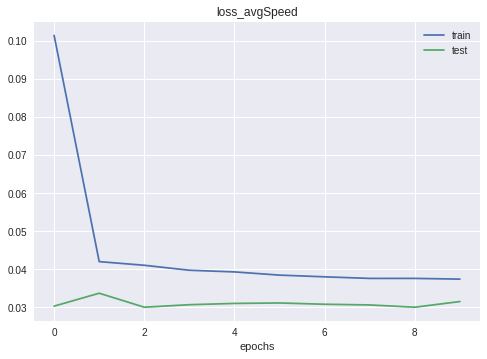

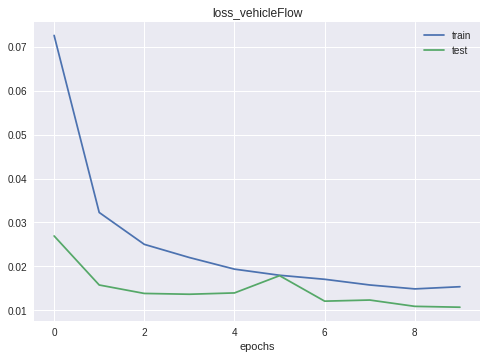

In [74]:
### train the model and predict the test set and I plot the graph of mae loss change with the increase of epoche
### the parameter of FORECAST is the size of output, col is the name of the predicted column, the function trainTheModel
### return the object of model
modelSpeed = trainTheModel(X_train,ySpeed_train,FORECAST,"loss_avgSpeed")
modelFlow = trainTheModel(X_train,yFlow_train,FORECAST, "loss_vehicleFlow")

We use a method called earlystopping when training the model, it will stop training when a monitored metric has stopped improving. So it can be save more time to train the model. It is also a regularization method to suppress overfitting


In [98]:
### Use the model to predict the values in test set
ySpeed_pred = modelSpeed.predict(X_test)
yFlow_pred = modelFlow.predict(X_test)
### Get the values of inverse transform, invert the value with the previous scaler
ySpeed_pred_, yFlow_pred_, ySpeed_test_, yFlow_test_ = InverseValues1(ySpeed_pred, yFlow_pred, ySpeed_test, yFlow_test, X_test, scaler)
### we can look the inverse values, for the output, the first column is the prediction
### of 5 minutes, second column is the prediction of 10 minutes...
ySpeed_pred_

array([[113.903175, 112.45474 , 114.62222 ],
       [113.03423 , 111.60352 , 113.9046  ],
       [112.37881 , 110.95297 , 113.323   ],
       ...,
       [114.04487 , 112.755455, 114.71513 ],
       [112.80966 , 111.442696, 113.68486 ],
       [114.69679 , 113.527054, 115.2237  ]], dtype=float32)

In [76]:
### It can be seen from the data set that the values of average speed and traffic 
### flow are both integers, so here we convert the float value predicted by the model to int
ySpeed_pred_ = ySpeed_pred_.astype(int)
yFlow_pred_ = yFlow_pred_.astype(int)
ySpeed_pred_

array([[113, 112, 114],
       [113, 111, 113],
       [112, 110, 113],
       ...,
       [114, 112, 114],
       [112, 111, 113],
       [114, 113, 115]])

In [77]:
### Get the MAE of every 5, 10, 15 minutes
for i in [0,1,2]:
    print("MAE for Speed Prediction + {} minutes= {}".format(i*5+5, mean_absolute_error(ySpeed_test_[:,i], ySpeed_pred_[:,i])))

for i in [0,1,2]:
    print("MAE for Flow Prediction + {} minutes= {}".format(i*5+5, mean_absolute_error(yFlow_test_[:,i], yFlow_pred_[:,i])))

MAE for Speed Prediction + 5 minutes= 6.181163954943679
MAE for Speed Prediction + 10 minutes= 6.812891113892365
MAE for Speed Prediction + 15 minutes= 6.600125156445557
MAE for Flow Prediction + 5 minutes= 25.5409887359199
MAE for Flow Prediction + 10 minutes= 35.94493116395494
MAE for Flow Prediction + 15 minutes= 50.21808510638298


The above value refers to the average absolute error between the predicted value of lstm and the true value. The smaller the value, the closer the predicted value is to the true value, that is, the higher the accuracy. The value of flowrate is large so the mae is larger. As the time to predict becomes longer, the error becomes greater.

### **Display the prediction and the true values**

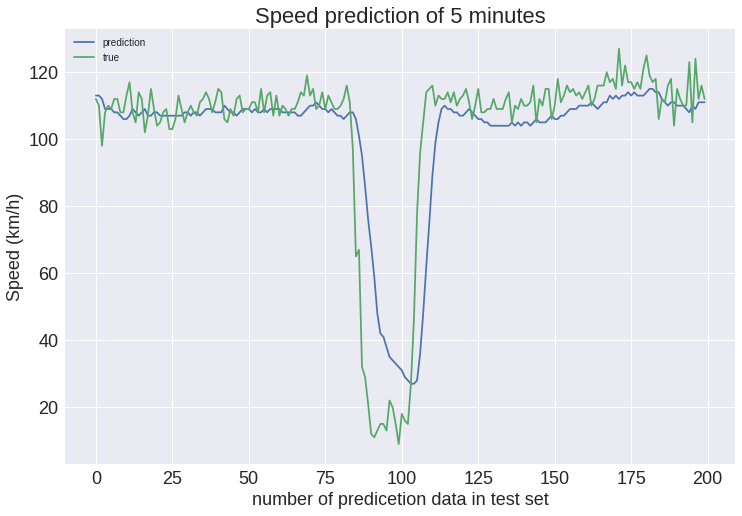

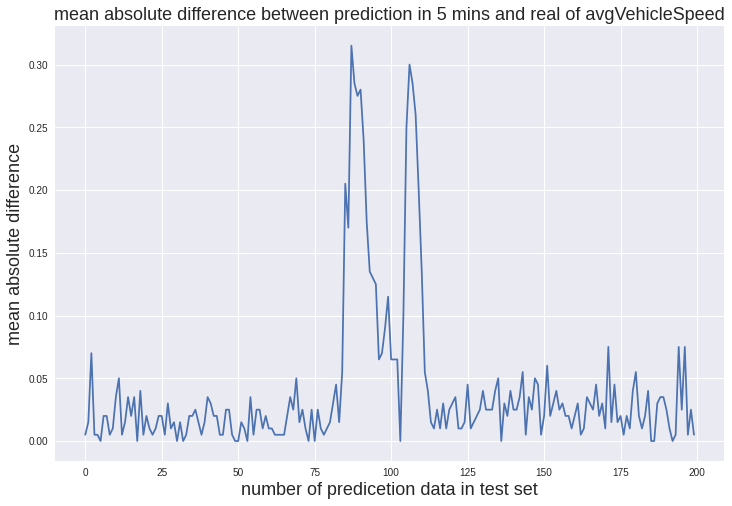

In [78]:
### Using graph to show the difference between predict values and real values
iStop=200

fig, ax = plt.subplots(figsize=(12,8))

plt.xticks(size=18)
plt.yticks(size=18)
ax.set_xlabel('number of predicetion data in test set', fontsize=18)
ax.set_ylabel('Speed (km/h)', fontsize=18)
ax.plot(ySpeed_pred_[:iStop,0], label='prediction')    
ax.plot(ySpeed_test_[:iStop,0], label='true')
ax.set_title('Speed prediction of {} minutes'.format(5), fontsize=22)
ax.legend()
plt.show()
### show the difference graph
showThedifference(ySpeed_pred_[:iStop, 0], ySpeed_test_[:iStop, 0], "mean absolute difference between prediction in 5 mins and real of avgVehicleSpeed")

Although there is a big difference between the predicted value and the real value on the image, but because the average speed of the car is of a small order of magnitude, the value of mae is relatively small. It can also be seen from the magnitude of difference that it is very small

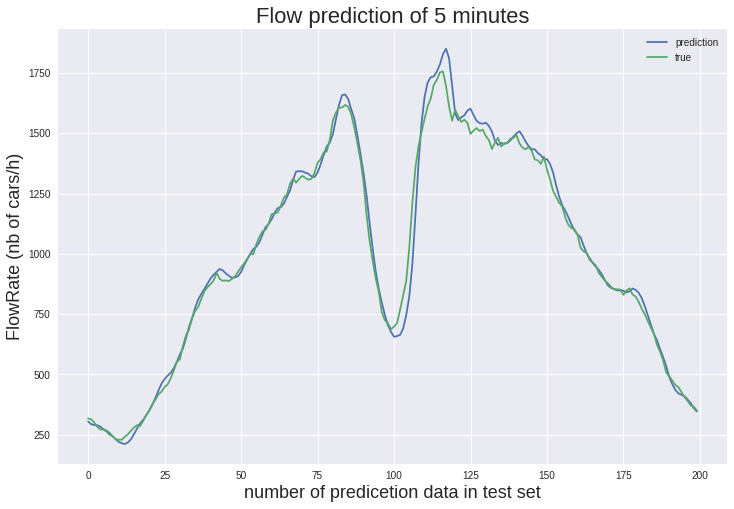

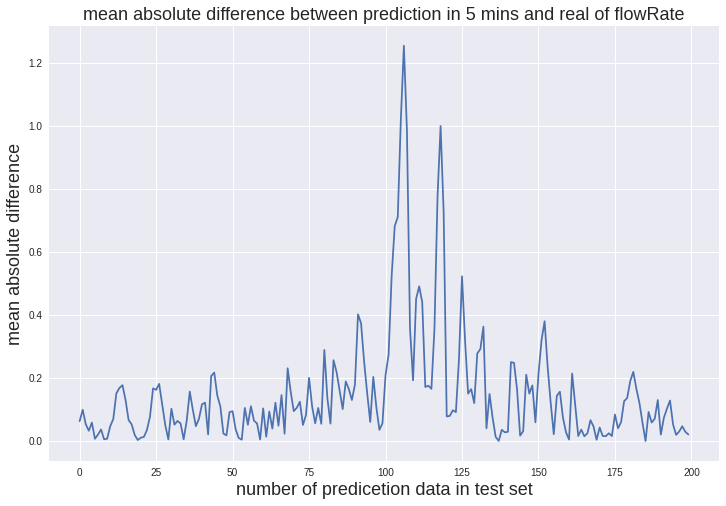

In [99]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('number of predicetion data in test set', fontsize=18)
ax.set_ylabel('FlowRate (nb of cars/h)', fontsize=18)
ax.plot(yFlow_pred_[:iStop,0], label='prediction')    
ax.plot(yFlow_test_[:iStop,0], label='true')
ax.set_title('Flow prediction of {} minutes'.format(5), fontsize=22)
ax.legend()
plt.show()

### show the difference graph
showThedifference(yFlow_pred_[:iStop, 0], yFlow_test_[:iStop, 0], "mean absolute difference between prediction in 5 mins and real of flowRate")

Although there is not much difference between the predicted value and the true value on the image, the value of mae is relatively large because the magnitude of the traffic flow value is relatively large. It can also be seen from the magnitude of difference that it larger than avgVehicleSpeed.

We will zoom in on some of the results on the test to look more clearly

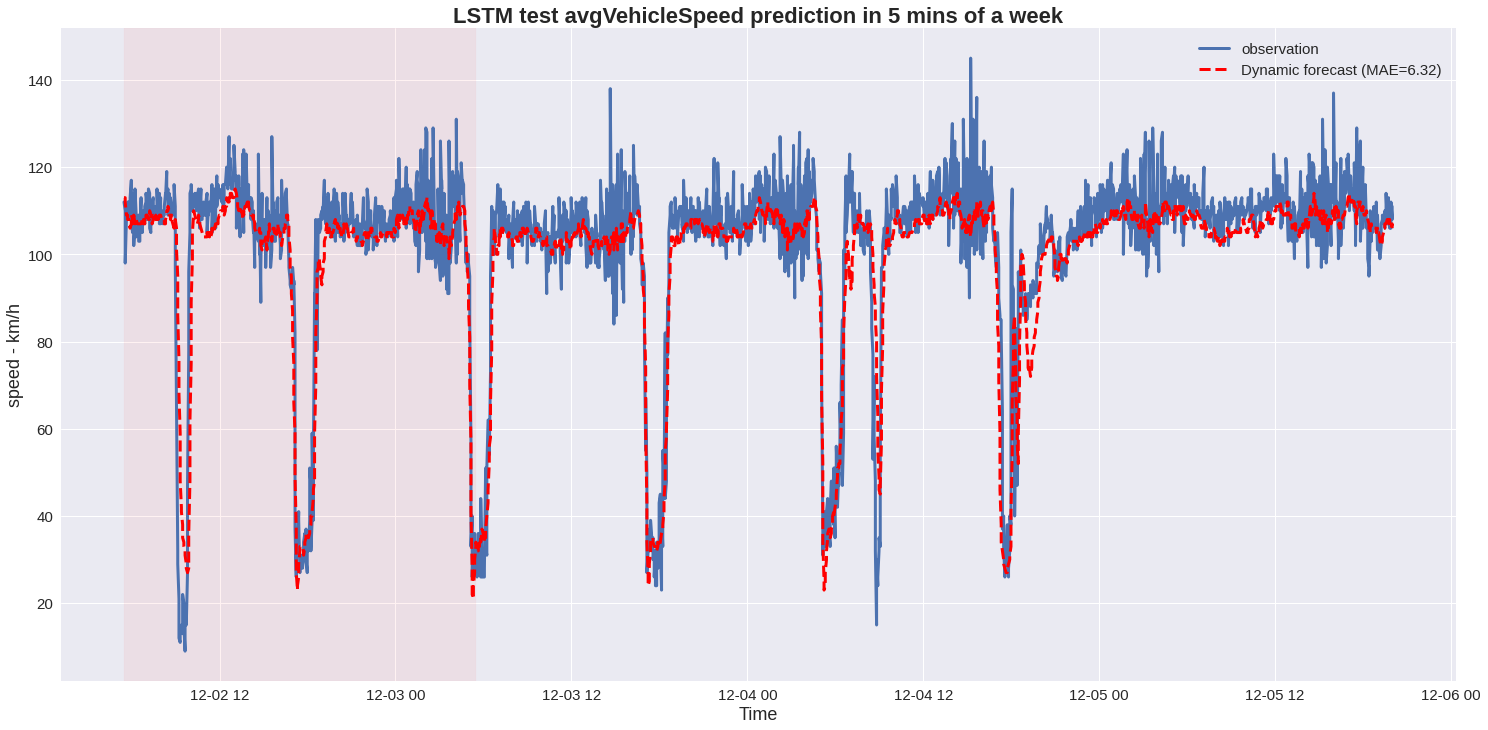

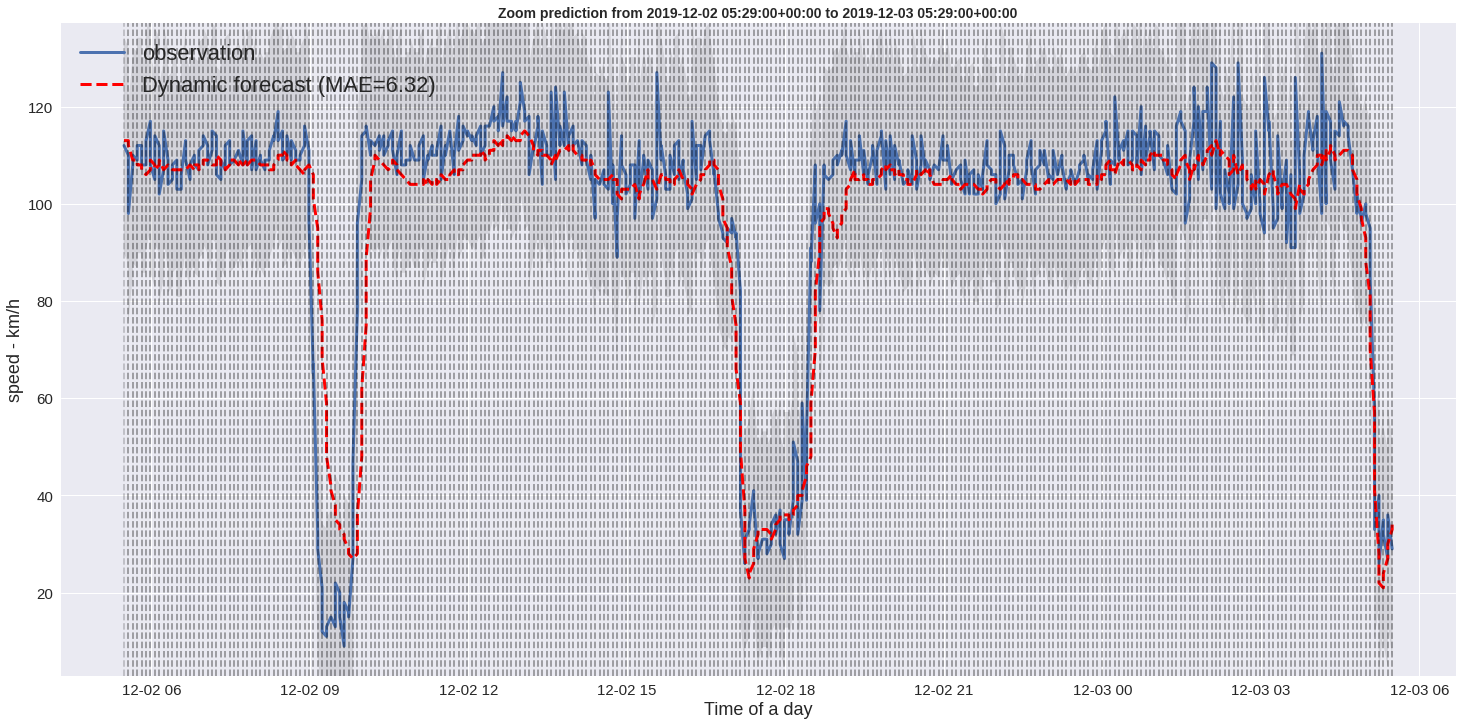

In [80]:
### here we select the data from december 2th to december 6th in test set and in the prediction
pre = pd.DataFrame(data=ySpeed_pred_[:2075,0], columns=['pre_speed'], index=data.index[7455:9530])
test = pd.DataFrame(data=ySpeed_test_[:2075, 0], columns=['speed'], index=data.index[7455:9530])

#print(np.std(data2['avgVehicleSpeed']) * 1.96 / np.sqrt(len(data)))
prediction_plot_var(std=np.std(data2['avgVehicleSpeed']), type='speed', df_original=test, df_forecast=pre, title='LSTM test avgVehicleSpeed prediction in 5 mins of a week', zoom=True, zoom_start_at='2019-12-02 05:29:00+00:00', zoom_end_at='2019-12-03 05:29:00+00:00', unit='km/h')

- Dynamic forecast means that every time a value is predicted, this value will be used as the input for the next forecast
- The value of the x-axis in the above figure, for example, '12-02 06' refers to december 2th at 6am
- The gray part is the standard deviation

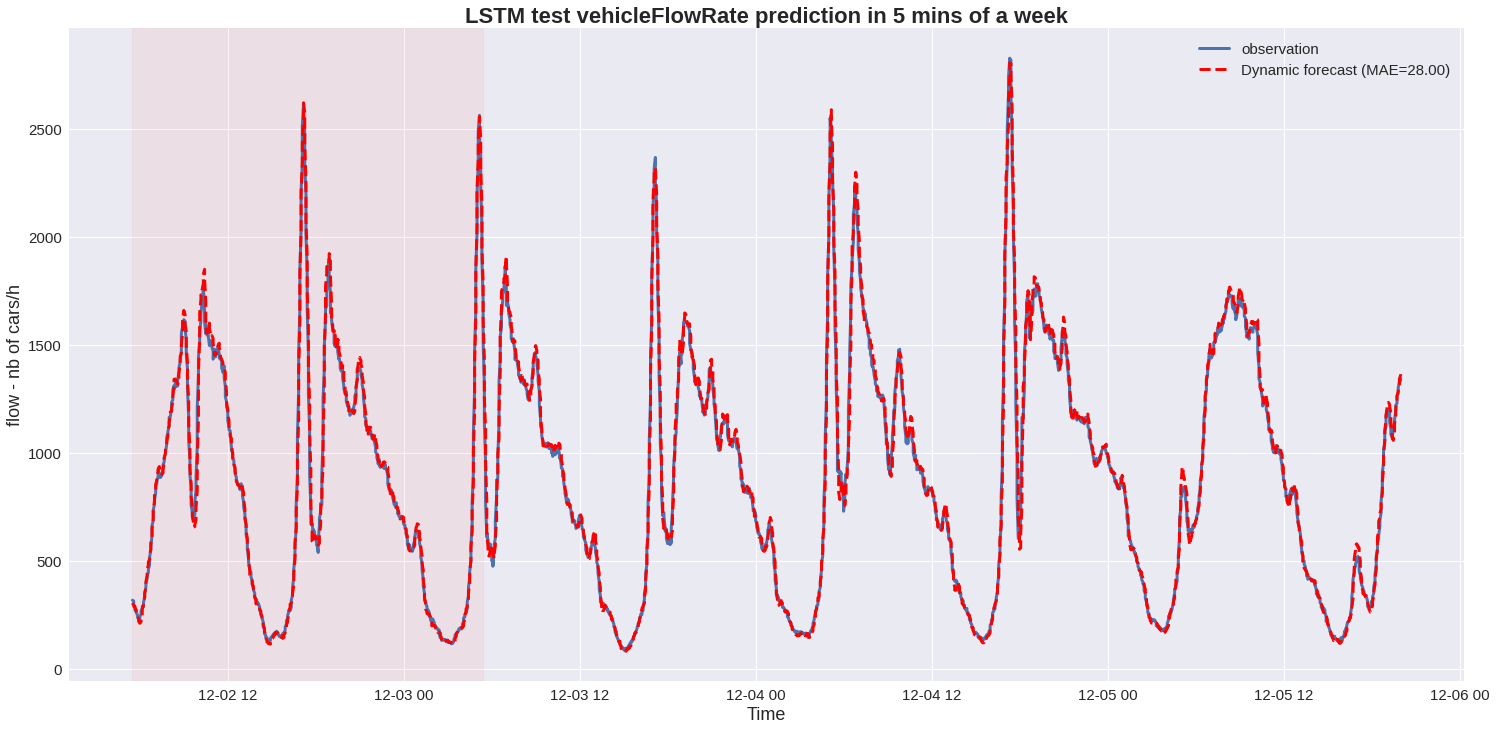

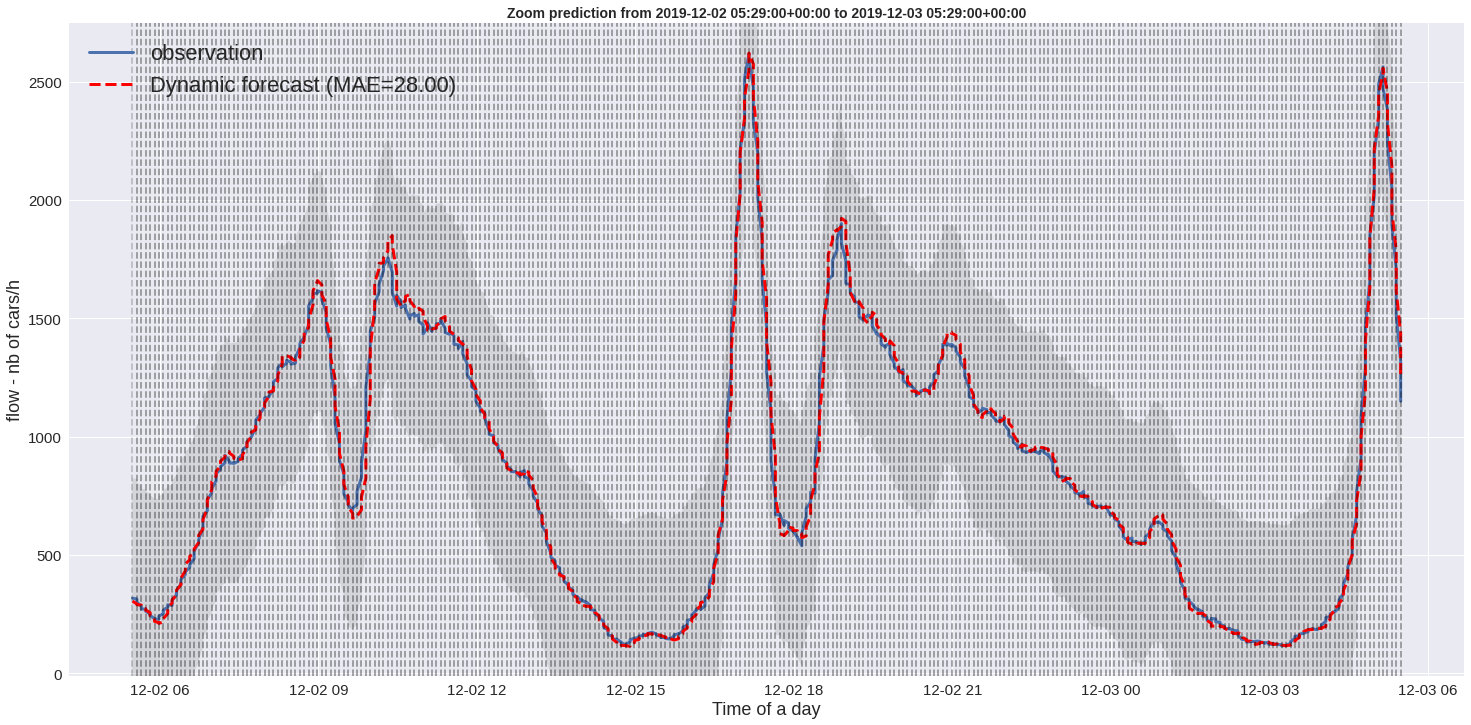

In [81]:
### select the same time period for the prediction flow
pre = pd.DataFrame(data=yFlow_pred_[:2075,0], columns=['pre_flow'], index=data.index[7455:9530])
test = pd.DataFrame(data=yFlow_test_[:2075, 0], columns=['flow'], index=data.index[7455:9530])
### show the graph
prediction_plot_var(np.std(data2['vehicleFlowRate']), 'flow', test, pre, title='LSTM test vehicleFlowRate prediction in 5 mins of a week', zoom=True, zoom_start_at='2019-12-02 05:29:00+00:00', zoom_end_at='2019-12-03 05:29:00+00:00', unit='nb of cars/h')

Good prediction
It can be seen that the prediction of flow is almost the same


### **Dealing with a Multivariate Time Series – VAR**

In this section, I will introduce you to one of the most commonly used methods for multivariate time series forecasting – Vector Auto Regression (VAR).



In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables. To explain this in a better manner, I’m going to use a simple visual example:

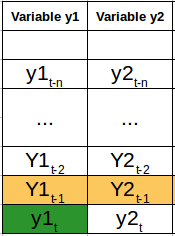        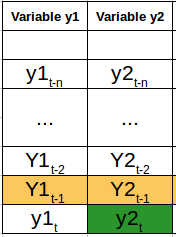

We have two variables, y1 and y2. We need to forecast the value of these two variables at time t, from the given data for past n values. For simplicity, I have considered the lag value to be 1.





For calculating y1(t), we will use the past value of y1 and y2. Similarly, to calculate y2(t), past values of both y1 and y2 will be used. Below is a simple mathematical way of representing this relation:

image.png

image.png

Here,

  - a1 and a2 are the constant terms,
  - w11, w12, w21, and w22 are the coefficients,
  - e1 and e2 are the error terms

These equations are similar to the equation of an AR process. Since the AR process is used for univariate time series data, the future values are linear combinations of their own past values only. Consider the AR(1) process:

    y(t) = a + w*y(t-1) +e

In this case, we have only one variable – y, a constant term – a, an error term – e, and a coefficient – w. In order to accommodate the multiple variable terms in each equation for VAR, we will use vectors.  We can write the equations (1) and (2) in the following form :
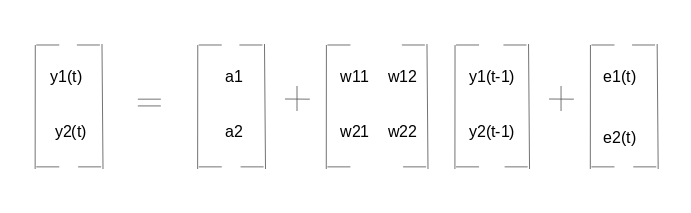

The two variables are y1 and y2, followed by a constant, a coefficient metric, lag value, and an error metric. This is the vector equation for a VAR(1) process. For a VAR(2) process, another vector term for time (t-2) will be added to the equation to generalize for p lags:

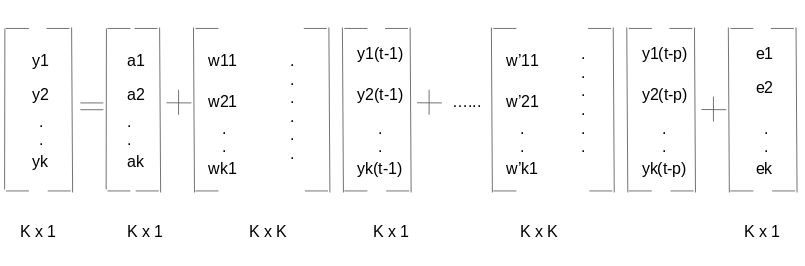

As you increase the number of time series (variables) in the model the system of equations become larger.

### **Building a VAR model in Python**

We have done the analysis of the time series before, so the first step here is testing for causality amongst the time series.

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

### **Testing Causality using Granger’s Causality Test**

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [82]:
### here we can apply the df above directly
grangers_causation_matrix(df, variables = df.columns)

avgVehicleSpeed_x  ...  pre_vehicleFlowRate_x
avgVehicleSpeed_y                    1.0  ...                    0.0
vehicleFlowRate_y                    0.0  ...                    0.0
pre_avgVehicleSpeed_y                0.0  ...                    0.0
pre_vehicleFlowRate_y                0.0  ...                    1.0

[4 rows x 4 columns]

The row are the Response (Y) and the columns are the predictor series (X).

- For example, if you take the value 0.0 in (row 1, column 2), it refers to the p-value of ```vehicleFlowRate_x``` causing ```avgVechicleSpeed_y```. Whereas, the 0.0 in (row 2, column 1) refers to the p-value of ```vehicleFlowRate_y``` causing ```avgVehicleSpeed_x```.

So, how to interpret the p-values?

- If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

Next, let’s do the Cointegration test.

### **Cointegration Test**

Non-stationary series are likely to have pseudo-regression. The meaning of cointegration is to test whether their causal relationship is pseudo-regression, that is, to test whether there is a stable relationship between variables. Therefore, the causality test for non-stationary series is the cointegration test

But before we do the Cointegration test, introduce something about it. 

- Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.


To understand this test, we first need to know what is ‘order of integration’ (d).

- Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when we have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

- When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.


In [83]:
cointegration_test(df)

Name			| Test Statistic| Critical Value(95%)	| Cointegrated  
 ----------------------------------------------------------------------------------------------------
avgVehicleSpeed 	| 1296.04   	| 40.1749  		| True
vehicleFlowRate 	| 582.1     	| 24.2761  		| True
pre_avgVehicleSpeed 	| 152.0     	| 12.3212  		| True
pre_vehicleFlowRate 	| 2.96      	| 4.1296   		| False


There are three time series cointegrated, it means they have a long run, statistically significant relationship, which is the basic premise on which VAR models is based on.



### **Check for Stationarity and Make the Time Series Stationary**

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

Just to refresh, a stationary time series is one whose characteristics like mean and variance does not change over time.



In [84]:
### Divide the data into the training set and the test set. The data of lstm is 
### not used directly because the input dimensions are different, so I will re-divide it here.
nobs = math.floor(len(df) * 0.7)
df_train, df_test = df[0:nobs], df[nobs:]
### ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "avgVehicleSpeed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.4535
 No. Lags Chosen       = 27
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "vehicleFlowRate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4986
 No. Lags Chosen       = 36
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pre_avgVehicleSpeed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-St

Based on the ADF test, all the three series are confirmed to be stationary.

### **Select the Order (P) of VAR model**

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data.Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.

In [85]:
model = VAR(endog = df_train[['avgVehicleSpeed', 'vehicleFlowRate']], exog = df_train[['pre_avgVehicleSpeed', 'pre_vehicleFlowRate']])
x = model.select_order(maxlags=12)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In order to be consistent with LSTM, we choose lag=10. It can also be seen from the figure that when lag=10, the value of AIC is almost the same as the minimum value.

### **Train the VAR Model with selected order(p)**


In [86]:
model_fitted = model.fit(10, method='ols', ic='aic', verbose=True)
model_fitted.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 10, BIC -> 9, FPE -> 10, HQIC -> 9>
Using 10 based on aic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Jun, 2021
Time:                     08:00:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.5122
Nobs:                     7454.00    HQIC:                   10.4842
Log likelihood:          -60127.6    FPE:                    35226.9
AIC:                      10.4696    Det(Omega_mle):         35010.6
--------------------------------------------------------------------
Results for equation avgVehicleSpeed
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      8.271711         0.527496           15.681           0.000
exog0                      0.423446         0.009429           44.910           0.000
exog1                      0.0

- The prob in the table corresponds to the p-value. If the value is less than 0.05, we reject the null hypothesis, which means that this variable is significant for the variable to be predicted. Based on two tables above, we can obtain two equations with significant variables. Since there are many formula coefficients, I will not list the specific formulas here.
- For some high-order terms, if its coefficient is small, we can also ignore it



### **Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).


If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

Durbin Watson Statistic 

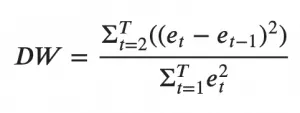

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.



In [87]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

avgVehicleSpeed : 1.96
vehicleFlowRate : 1.98


The serial correlation seems quite alright.


## **Prediction of model VAR**

In [88]:
### Input is the same as the model LSTM, the average vehicle speed and traffic volume values of the current and previous cameras
### Output is the prediction of 5 minutes
lag_order = model_fitted.k_ar

### let's look the input
forecast_input = df_train[['avgVehicleSpeed', 'vehicleFlowRate']].values[5389-lag_order:5389]
forecast_input

array([[114., 450.],
       [121., 434.],
       [117., 422.],
       [109., 416.],
       [112., 395.],
       [111., 385.],
       [115., 374.],
       [119., 353.],
       [115., 339.],
       [108., 333.]])

Here I introduce a little about in-sample forecast and out-of-sample forecast.

If you are forecasting for an observation that was part of the data sample - it is in-sample forecast.

If you are forecasting for an observation that was not part of the data sample - it is out-of-sample forecast.

If it was used for the model fitting, then the forecast of the observation is in-sample. Otherwise it is out-of-sample.

In [89]:
### Forecast in-sampling, the input is used in training set and for the model fitting
fc = model_fitted.forecast(y=forecast_input, steps=2075, exog_future=df_train[['pre_avgVehicleSpeed', 'pre_vehicleFlowRate']][5389:])
fc = fc.astype(int)
df_forecast = pd.DataFrame(fc, index=df_train[5389:].index, columns=df_train.columns[:2] + '_forecast')
df_forecast

avgVehicleSpeed_forecast  vehicleFlowRate_forecast
date_time                                                                    
2019-12-08 00:04:00+00:00                       116                       328
2019-12-08 00:09:00+00:00                       113                       325
2019-12-08 00:14:00+00:00                       111                       323
2019-12-08 00:19:00+00:00                       114                       325
2019-12-08 00:24:00+00:00                       114                       329
...                                             ...                       ...
2019-12-15 05:14:00+00:00                       116                       435
2019-12-15 05:19:00+00:00                       113                       450
2019-12-15 05:24:00+00:00                       113                       463
2019-12-15 05:29:00+00:00                       114                       475
2019-12-15 05:34:00+00:00                       123                       487

[2075 rows x 2 columns]

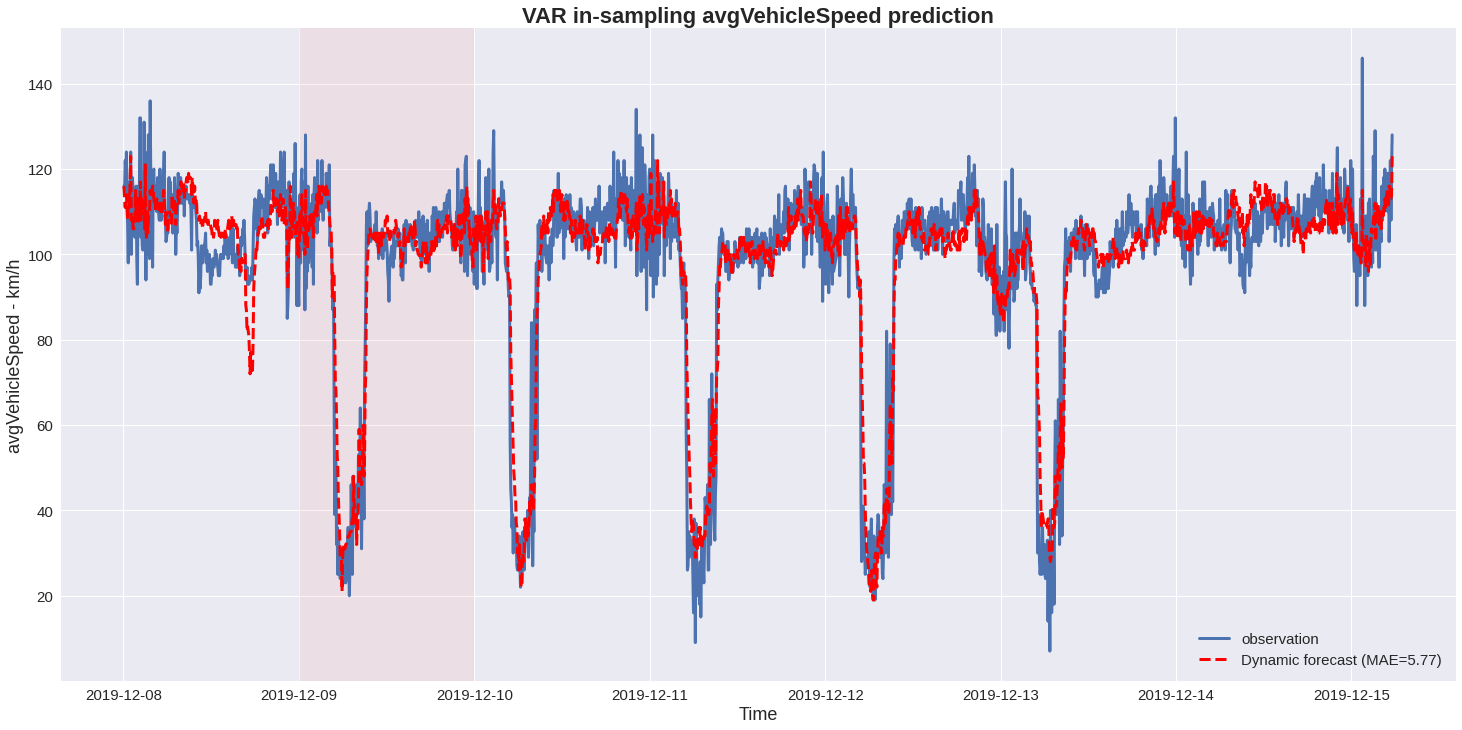

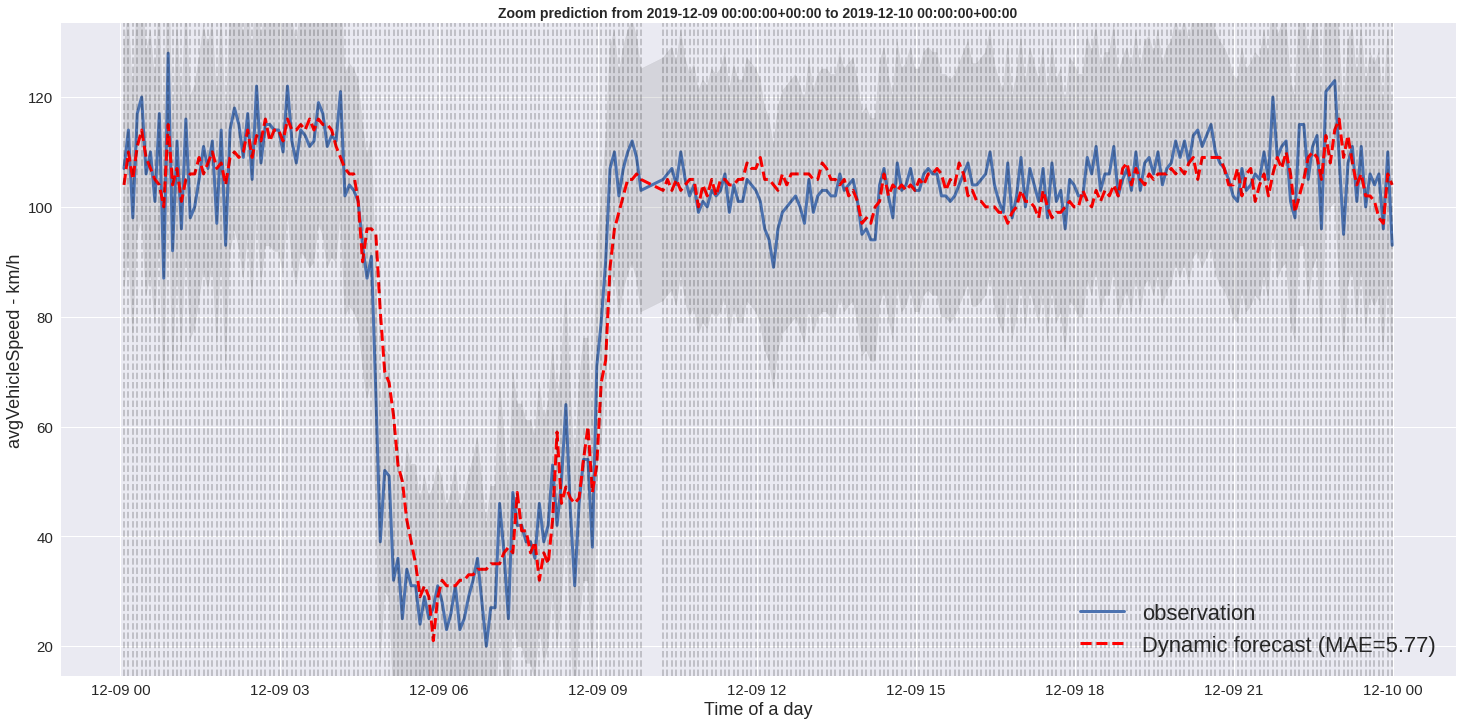

In [90]:
### plot one week and zoom one day
prediction_plot_var(df_original=df_train['avgVehicleSpeed'][5389:], df_forecast=df_forecast['avgVehicleSpeed_forecast'], title='VAR in-sampling avgVehicleSpeed prediction', zoom=True, zoom_start_at='2019-12-09 00:00:00+00:00', zoom_end_at='2019-12-10 00:00:00+00:00',unit='km/h', std=np.std(data2['avgVehicleSpeed']), type='avgVehicleSpeed')

The general predictions are not bad

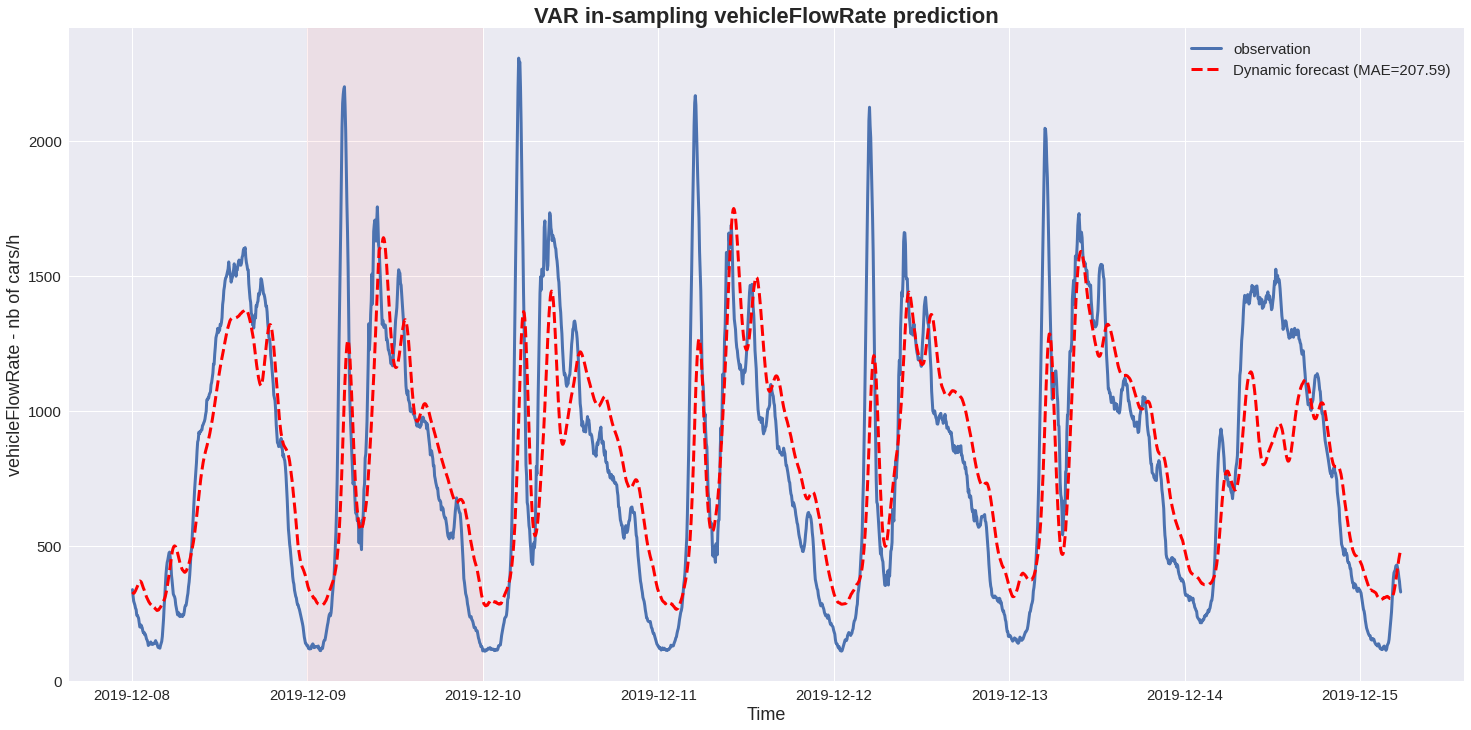

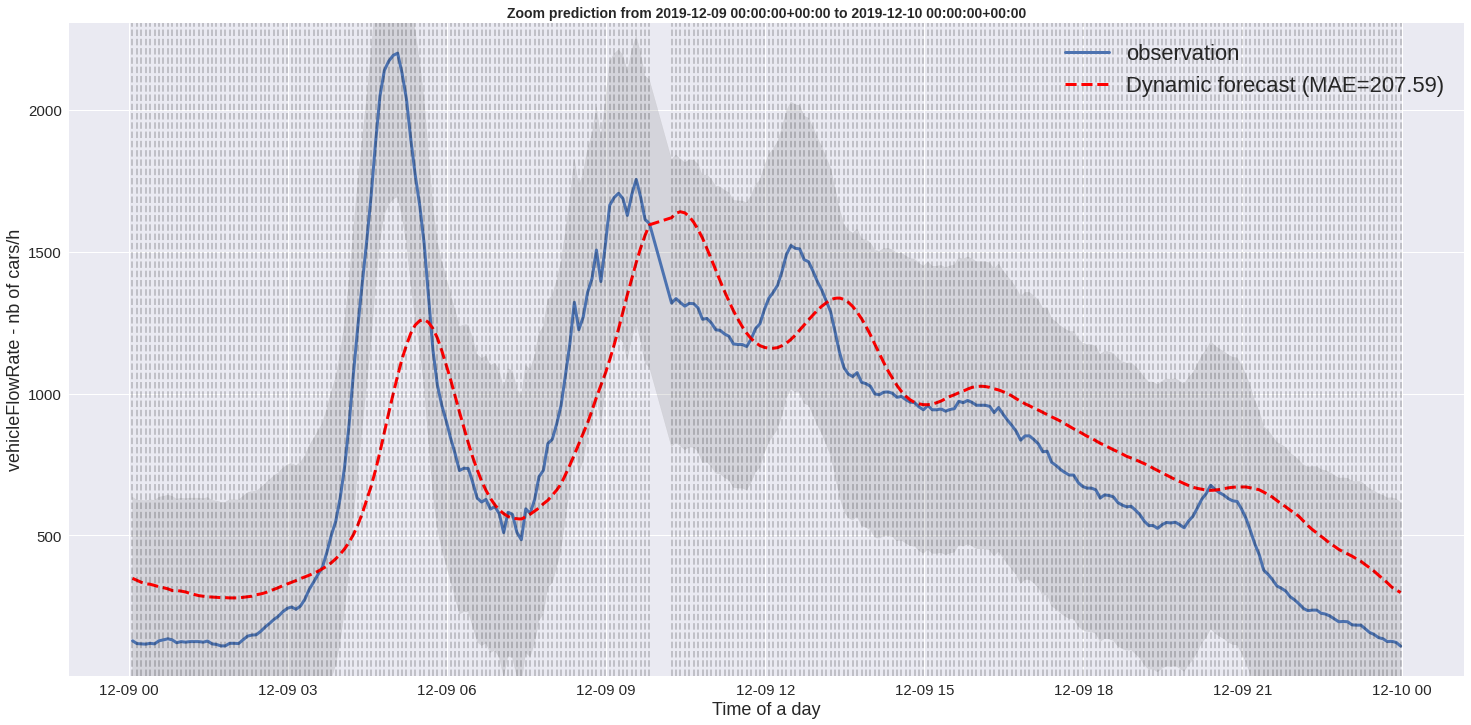

In [91]:
prediction_plot_var(df_original=df_train['vehicleFlowRate'][5389:], df_forecast=df_forecast['vehicleFlowRate_forecast'], title='VAR in-sampling vehicleFlowRate prediction',zoom=True, zoom_start_at='2019-12-09 00:00:00+00:00', zoom_end_at='2019-12-10 00:00:00+00:00', unit='nb of cars/h',  std=np.std(data2['vehicleFlowRate']), type='vehicleFlowRate')

We can see that the VAR model performs well in avgSpeed on the training set, but te mae is a bit large in FlowRate, because the value of flowrate is large so after the mae it can be much larger. We continue to make out-of-sampling prediction on the testing set.

In [92]:
### Forecast out-of-sampling, the input is in test set
lag_order = model_fitted.k_ar

forecast_input2 = df_train[['avgVehicleSpeed', 'vehicleFlowRate']].values[-lag_order:]
fc2 = model_fitted.forecast(y=forecast_input2, steps=3199, exog_future=df_test[['pre_avgVehicleSpeed', 'pre_vehicleFlowRate']])
fc2 = fc2.astype(int)
df_forecast2 = pd.DataFrame(fc2, index=df_test.index, columns=df_train.columns[:2] + '_forecast')
df_results = df_forecast2[:200]
df_forecast2

avgVehicleSpeed_forecast  vehicleFlowRate_forecast
date_time                                                                    
2019-12-15 05:39:00+00:00                       119                       313
2019-12-15 05:44:00+00:00                       118                       299
2019-12-15 05:49:00+00:00                       117                       290
2019-12-15 05:54:00+00:00                       111                       280
2019-12-15 05:59:00+00:00                       116                       275
...                                             ...                       ...
2019-12-26 08:14:00+00:00                       116                       406
2019-12-26 08:19:00+00:00                       124                       413
2019-12-26 08:24:00+00:00                       122                       422
2019-12-26 08:29:00+00:00                       119                       427
2019-12-26 08:34:00+00:00                       118                       431

[3199 rows x 2 columns]

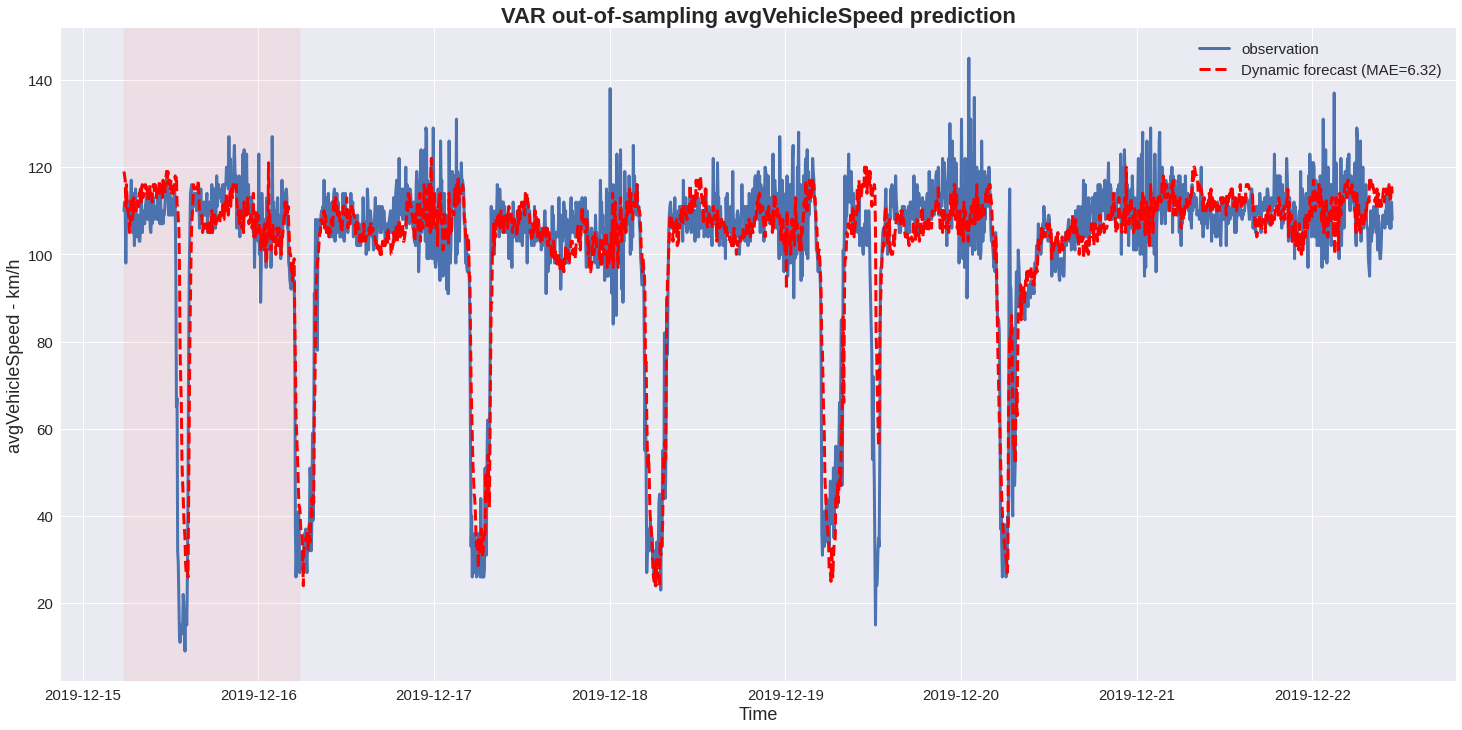

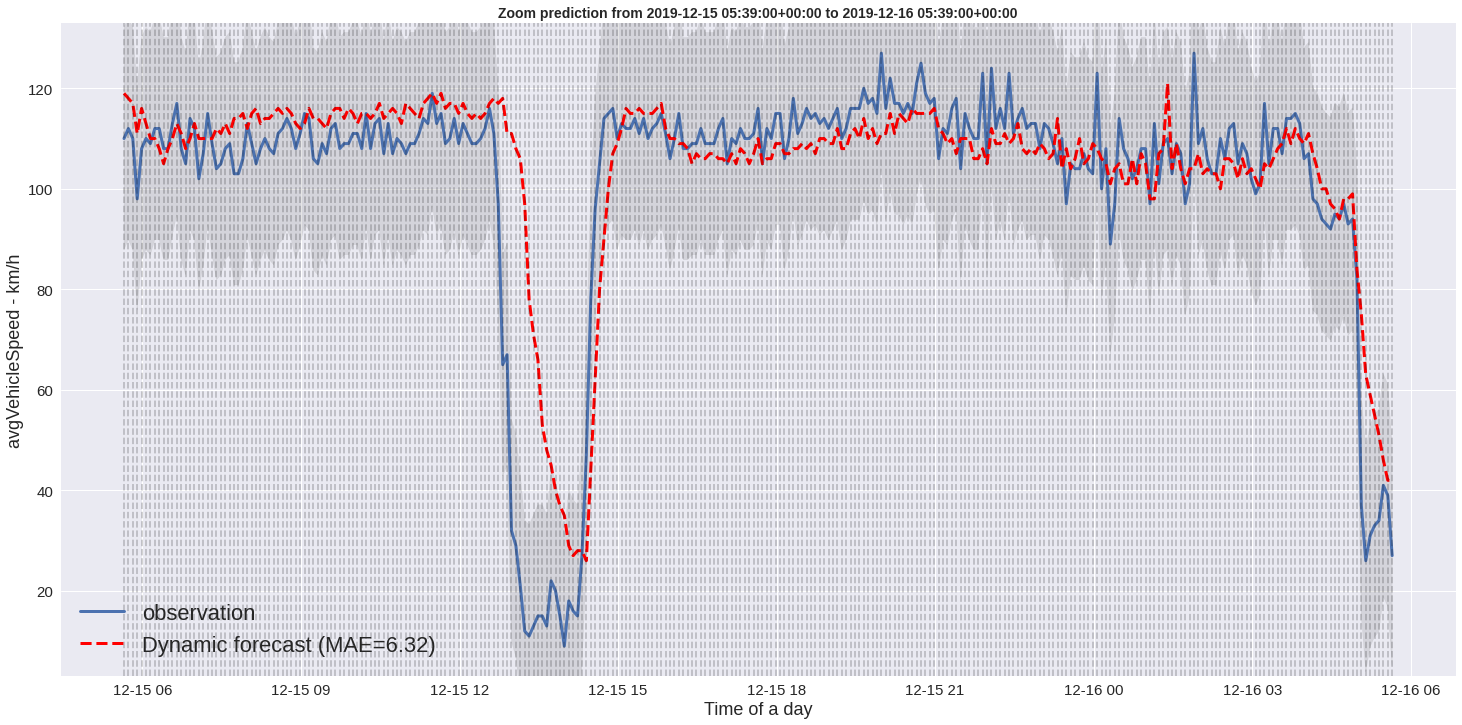

In [93]:
prediction_plot_var(df_original=df_test['avgVehicleSpeed'][:2075], df_forecast=df_forecast2['avgVehicleSpeed_forecast'][:2075], title='VAR out-of-sampling avgVehicleSpeed prediction', zoom=True, zoom_start_at='2019-12-15 05:39:00+00:00', zoom_end_at='2019-12-16 05:39:00+00:00', unit='km/h', std=np.std(data2['avgVehicleSpeed']), type='avgVehicleSpeed')

The effect is good based on the one-week forecast, but if you zoom in, you will find that there are still some deviation. Because some of the forecasts are not in the gray area

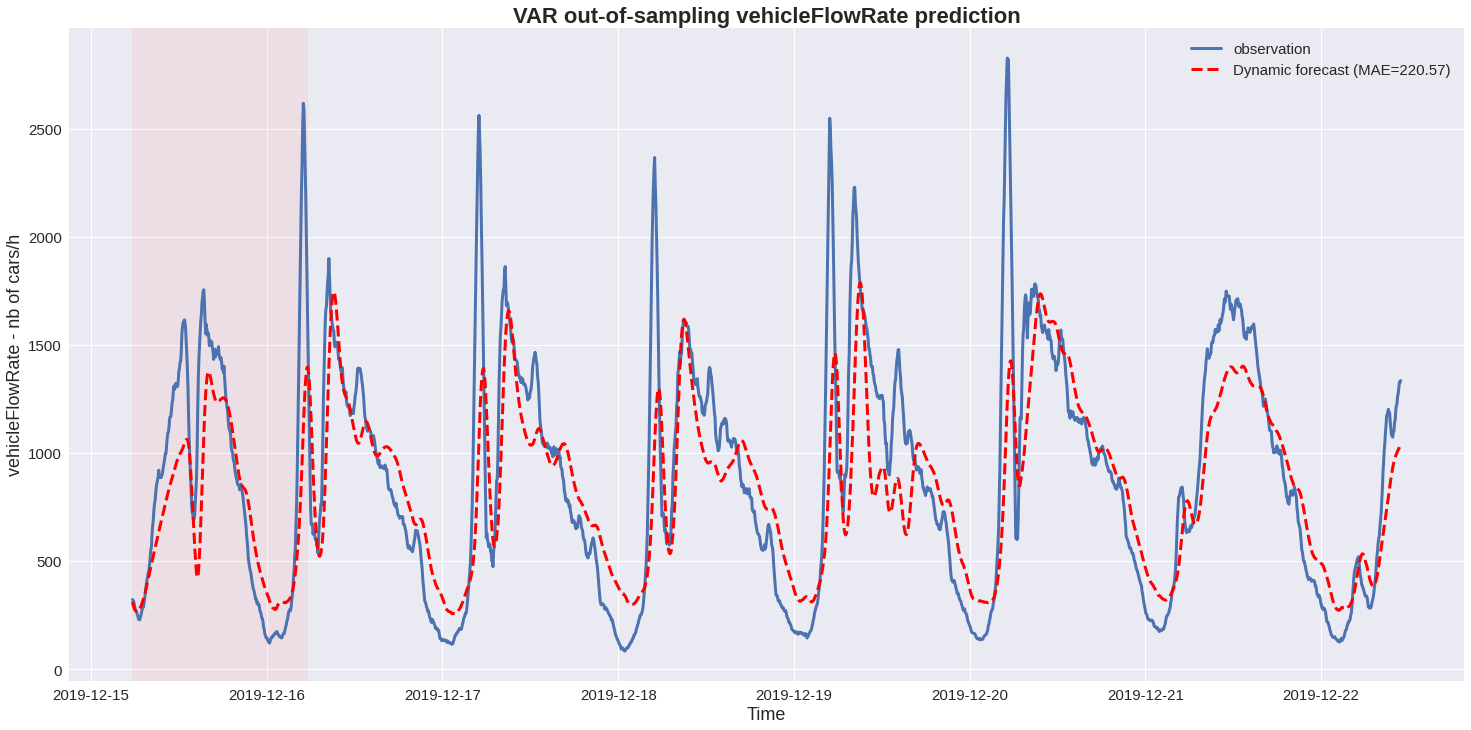

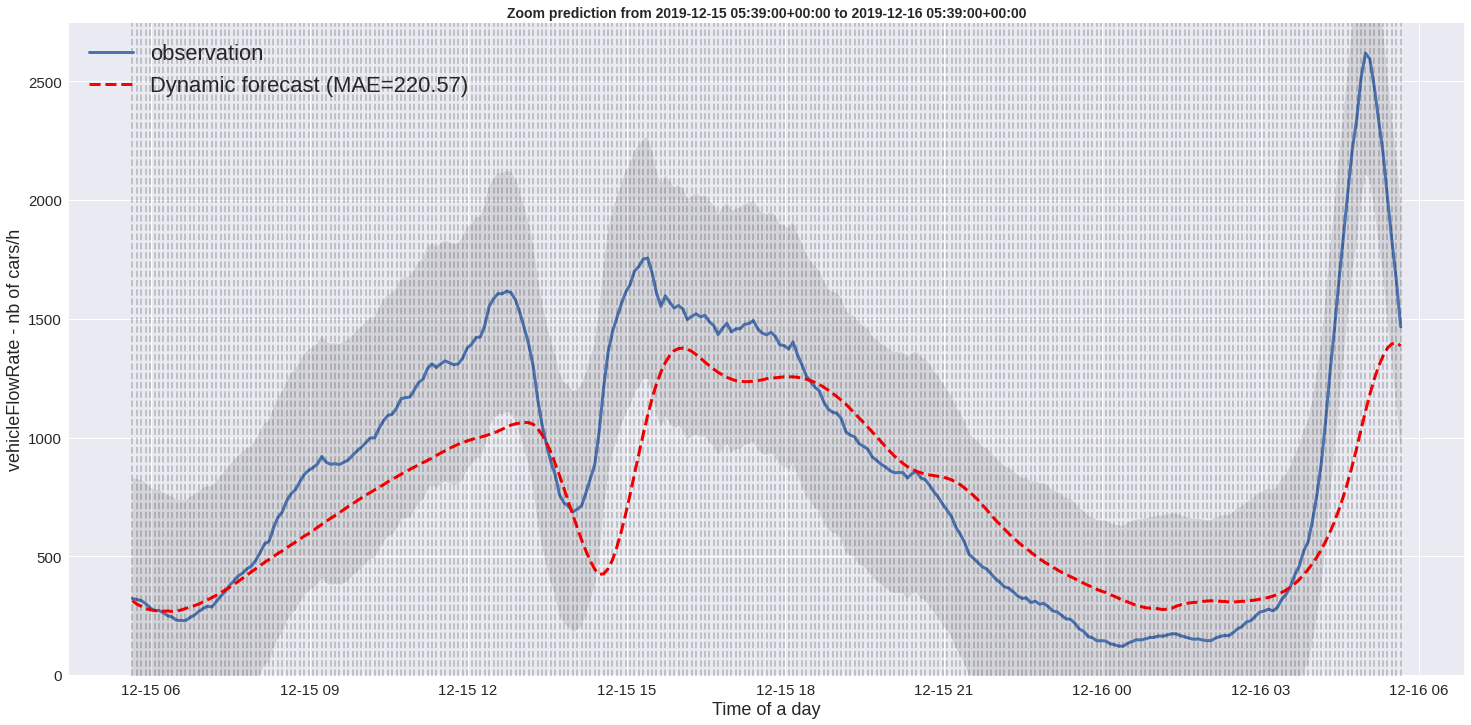

In [94]:
prediction_plot_var(df_original=df_test['vehicleFlowRate'][:2075], df_forecast=df_forecast2['vehicleFlowRate_forecast'][:2075], title='VAR out-of-sampling vehicleFlowRate prediction', zoom=True, zoom_start_at='2019-12-15 05:39:00+00:00', zoom_end_at='2019-12-16 05:39:00+00:00', unit='nb of cars/h', std=np.std(data2['vehicleFlowRate']), type='vehicleFlowRate')

The var model also has some errors in the prediction of traffic flow, but because it has a large order of magnitude, the corresponding mae will also be large.

In fact, from the zoom we can see that the model LSTM is better than VAR especially in the prediction of vehicleFlowRate. But we still have to make a comparison

## **Compare the results of two models**

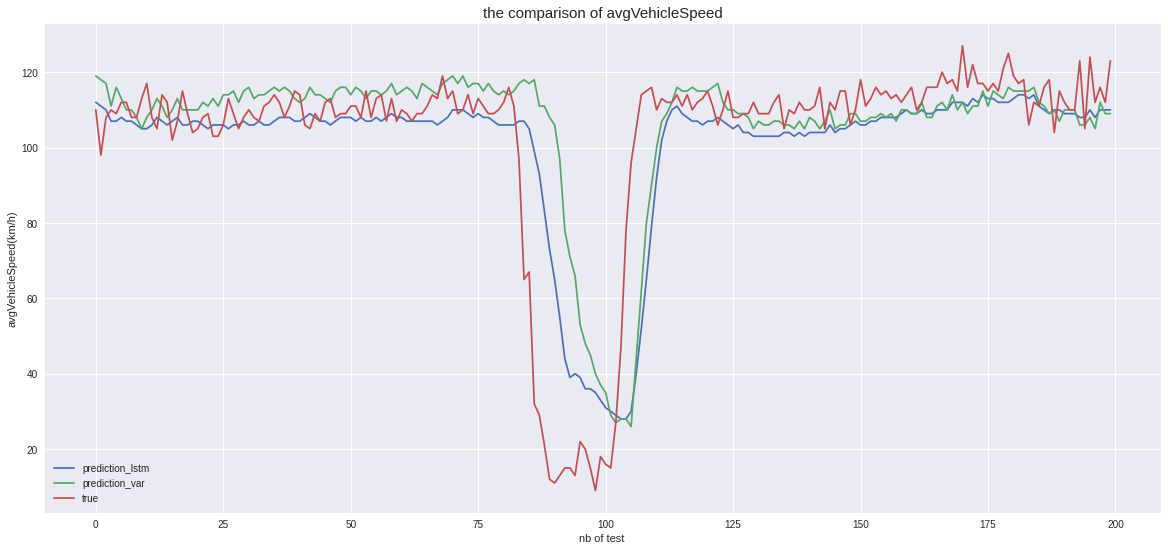

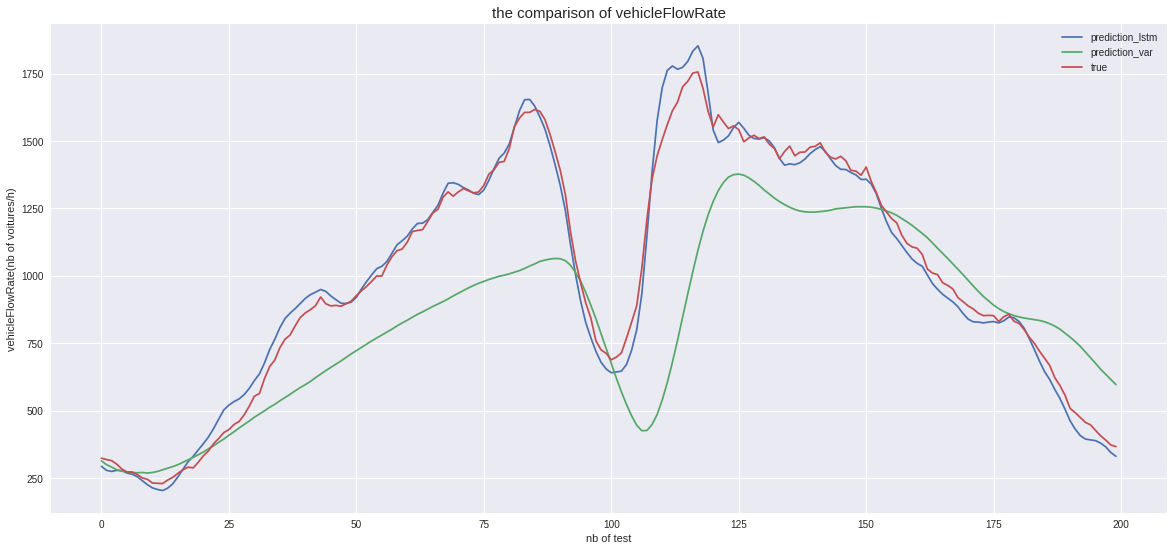

In [97]:
### precision of avgVehicleSpeed
#df_results = df_forecast2[:2075]
fig, ax = plt.subplots(figsize=(20,9))
ax.set_title("the comparison of avgVehicleSpeed", fontsize=15)
ax.set_xlabel("nb of test ")
ax.set_ylabel("avgVehicleSpeed(km/h)")
plt.plot(ySpeed_pred_[:200,1], label='prediction_lstm') 
plt.plot(df_results['avgVehicleSpeed_forecast'].to_numpy(), label='prediction_var') 
plt.plot(ySpeed_test_[:200,1], label='true')
plt.legend()
plt.show()
### precision of vehicleFlowRate
fig, ax = plt.subplots(figsize=(20,9))
ax.set_title("the comparison of vehicleFlowRate", fontsize=15)
ax.set_xlabel("nb of test")
ax.set_ylabel("vehicleFlowRate(nb of voitures/h)")
plt.plot(yFlow_pred_[:200,1], label='prediction_lstm') 
plt.plot(df_results['vehicleFlowRate_forecast'].to_numpy(), label='prediction_var') 
plt.plot(df_test['vehicleFlowRate'].to_numpy()[:200], label='true')
plt.legend()
plt.show()

- we can see that the predictions in LSTM and VAR are similar in average of vehicle speed, both have a certain error from the actual value.
- For the prediction of traffic volume, the prediction of lstm is obviously better than that of the var model. var only predicts a general trend, there is no obvious volatility
- Perhaps in the linear equation of var, the coefficient of some terms is 0 (the lag time value is not used)
- So generally speaking, the lstm model is better than var in this project

We will make a table to compare the metric MAE of the two models.

In [96]:
mae_speed_lstm = mean_absolute_error(ySpeed_test_, ySpeed_pred_)
mae_speed_var = mean_absolute_error(df_test['avgVehicleSpeed'].to_numpy(), df_forecast2['avgVehicleSpeed_forecast'].to_numpy())
mae_flow_lstm = mean_absolute_error(yFlow_test_, yFlow_pred_)
mae_flow_var = mean_absolute_error(df_test['vehicleFlowRate'].to_numpy(), df_forecast2['vehicleFlowRate_forecast'].to_numpy())
maes = np.array([mae_speed_lstm, mae_speed_var, mae_flow_lstm, mae_flow_var])
maes = pd.DataFrame(data=maes.reshape((1,4)), columns=['mae_speed_lstm(km/h)', 'mae_speed_var(km/h)', 'mae_flow_lstm(nb of vehicles/h)', 'mae_flow_var(nb of vehicles/h)'], index = ['MAE'])
maes

mae_speed_lstm(km/h)  ...  mae_flow_var(nb of vehicles/h)
MAE              6.531393  ...                      211.588309

[1 rows x 4 columns]

Clearly, we see that the mae of vehicleFlowRate in test set has a big gap between LSTM and VAR. 

The value of mae is consistent with the representation of the image. The two models for predicting the average speed of vehicles are similar, but for the prediction of traffic flow, the mae of lstm is significantly smaller than var, so the prediction result is better.

In summary, maybe we can use the VAR model to predict vehicle speed in the future, because it is simpler than LSTM, the model training time is shorter, and it has similar effects. For the prediction of traffic flow, we should choose the LSTM model, because it has a higher accuracy in the prediction on the test set.
